# Contexto de Negócio

## Desáfio

Vamos supor que você foi contratada pela empresa Netflix e ela deseja um modelo preditivo para prever as notas de filmes, para assim decidir se vale a pena ou não colocar esse filme no catálogo. Você daria conta desse desafio?

## Entregáveis

a) Tratamento dos dados.

b) Feature engeneering.

c) Divisão da base de dados entre dataset teste e dataset treino.

d) A Matriz de Confusão do seu modelo de testes assim como o gráfico de precision e recall do seu modelo.

e) Tendo em vista o resultado final o que você faria para melhorar o modelo?

# 0.0. Bibliotecas

In [1]:
# stetic libraries
import warnings
from tabulate import tabulate
from IPython.core.display import HTML
from IPython.display import Image
import inflection

# data manipulation libraries
import re
import math
import datetime as dt
import pandas as pd

# data analysis libraries
import numpy as np
import seaborn as sns
import random

# data preparation
from sklearn.model_selection   import train_test_split,cross_val_score, RandomizedSearchCV
from sklearn.ensemble          import RandomForestClassifier, RandomForestRegressor, IsolationForest
from sklearn.feature_selection import RFE
from boruta                    import BorutaPy
from sklearn.preprocessing     import StandardScaler, MinMaxScaler, RobustScaler

# machine learning modeling
import random
import xgboost as xgb
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier

# metrics
from sklearn.metrics         import accuracy_score, balanced_accuracy_score, classification_report,cohen_kappa_score,recall_score,f1_score,roc_auc_score, plot_precision_recall_curve, precision_score,roc_curve
from scikitplot              import metrics      as mt
from sklearn.calibration     import calibration_curve,CalibratedClassifierCV
from sklearn.metrics import plot_precision_recall_curve
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.datasets import load_game

# deployment
import pickle
import streamlit as st

# using this method to change the scientific numbers
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# using this method to deactivate warnings
warnings.filterwarnings('ignore')

# 0.1. Funções

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [4]:
def ml_error(model_name,y,yhat):
    accuracy = accuracy_score(y, yhat)
    kappa = cohen_kappa_score(y, yhat)
    precision = precision_score(y, yhat, average='macro')
    recall = recall_score(y, yhat, average='macro')
    f1_sc = f1_score(y, yhat, average='macro')
    
    return pd.DataFrame([{'Model Name': model_name,
                         'Accuracy': accuracy,
                         'Kappa Score': kappa,
                         'Precision Score': precision,
                         'Recall Score': recall,
                         'F1-Score': f1_sc}])

In [5]:
def cross_validation_multiclass( X, y , kfold, model_name, model, verbose=True ):
    accuracy_list = []
    kappa_list = []
    precision_list = []
    recall_list = []
    f1_score_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
            
        X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2)

        # model
        m = model.fit( X_train.values, y_train.values )

        # prediction
        yhat = m.predict( X_test )

        # performance
        m_result = ml_error( model_name, y_test, yhat)

        # store performance of each kfold iteration
        
        accuracy_list.append(  m_result['Accuracy'] )
        kappa_list.append( m_result['Kappa Score'] )
        precision_list.append(  m_result['Precision Score'] )
        recall_list.append( m_result['Recall Score'] )
        f1_score_list.append( m_result['F1-Score'] )

    return pd.DataFrame( [{'Model Name': model_name,
                          'Accuracy CV': np.round( np.mean( accuracy_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( accuracy_list ), 2 ).astype( str ),
                          'Kappa Score CV': np.round( np.mean( kappa_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( kappa_list ), 2 ).astype( str ),
                          'Precision CV': np.round( np.mean( precision_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( precision_list ), 2 ).astype( str ),
                          'Recall CV': np.round( np.mean( recall_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( recall_list ), 2 ).astype( str ),
                          'F1-Score CV': np.round( np.mean( f1_score_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( f1_score_list ), 2 ).astype( str )}])

# 0.2. Carregando os Dados

Esses dados são originados de um desáfio recebido para realizar uma classificação multi-classes das notas que uma série/filme da Netflix receberia caso fosse lançado.

In [6]:
# lendo os dados
df_raw = pd.read_csv('data/dataset_netflix.csv')

In [7]:
# checagem inicial dos dados
df_raw.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",9/9/2019,2019.00,41.00,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,9/9/2016,2016.00,52.00,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,8/9/2018,2013.00,82.00,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,8/9/2018,2016.00,64.00,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,8/9/2017,2017.00,57.00,99 min,Comedies,When nerdy high schooler Dani finally attracts...


# 1.0. Etapa 01 - Descrição dos Dados

In [8]:
# copiando os dados para torná-los recuperáveis mais tarde
df1 = df_raw.copy()

## 1.1. Data Dimensions

Checando as dimensões dos dados.

In [9]:
print(f'Número de linhas: {df1.shape[0]}')
print(f'Número de colunas: {df1.shape[1]}')

Número de linhas: 6234
Número de colunas: 12


## 1.2. Checking NA

In [10]:
# verificando a quantidade de NAs
df1.isna().sum()

show_id            0
type               0
title              0
director        1970
cast               1
country            1
date_added        12
release_year       1
rating             1
duration           1
listed_in          1
description        1
dtype: int64

## 1.3. Fillout NA

Optei por preencher os dados NA da seguinte forma, pois existem séries/filmes onde os diretores não são informados de fato e por isso acredito que deve ter sido o caso para o dato estar faltando aqui.

Quanto a exclusão das linhas vaizas de date_added, foi simplesmente porquê a quantidade de linhas vazias representava apenas 0,19% do total do dataset, desse modo eu a considerei de baixo valor para muito trabalho, além de levar as outras partes vazias de outras colunas com a exclusão dela.

In [11]:
# director
df1['director'] = df1['director'].fillna('not_informed')

In [12]:
# checando a densidade das faltas em date_added
12/6234

0.0019249278152069298

In [13]:
# date_added
df1 = df1[df1['date_added'].isna() == False]

In [14]:
# checando a quantidade de linhas remanescentes
df1.shape

(6222, 12)

In [15]:
# checando os vazios remanescentes
df1.isna().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

## 1.4. Checking Dtypes

Checando os tipos das colunas para poder modificá-los caso necessário.

In [16]:
# mostrando os tipos
df1.dtypes

show_id           int64
type             object
title            object
director         object
cast             object
country          object
date_added       object
release_year    float64
rating          float64
duration         object
listed_in        object
description      object
dtype: object

## 1.5. Chaging Dtypes

In [17]:
# mudando year para integer
df1['release_year'] = df1['release_year'].astype(int)

In [18]:
# mudando date_added para datetime
df1['date_added'] = pd.to_datetime(df1['date_added'])

In [19]:
# checando os tipos remanescentes
df1.dtypes

show_id                  int64
type                    object
title                   object
director                object
cast                    object
country                 object
date_added      datetime64[ns]
release_year             int64
rating                 float64
duration                object
listed_in               object
description             object
dtype: object

## 1.6. Descriptive Statistical

A variável de datetime64 não foi inclusa em nenhuma situação, pois ela não precisaria de uma análise estatística uma vez que apenas indica um momento no tempo e não um valor continuo ou pontual.

In [20]:
# separados as variáveis
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [21]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
                                       
# concatenate
                                       
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,show_id,247747.00,81235729.00,80987982.00,76708246.29,80163531.00,10950062.96,-5.15,30.31
1,release_year,1925.00,2020.00,95.00,2013.37,2016.00,8.77,-3.69,18.13
2,rating,0.00,97.00,97.00,64.10,68.00,19.02,-1.96,4.29


Desconsiderando o show_id (pois ele serve apenas como uma identificação) e o release_year (pois ele trata de um momento pontual no tempo, igual ao added_date), o rating aparenta estar conforme o padrão esperado.

## 1.7. Numerical Attributes Check

Aqui será checado o numerical attributes do rating apenas, pois ele é a única variável númerica que teria alguma variabilidade sem não-pontual (não é referente a identificação ou momentos pontuais no tempo). Logo, há lógica olhar os outliers referente a essa variável.

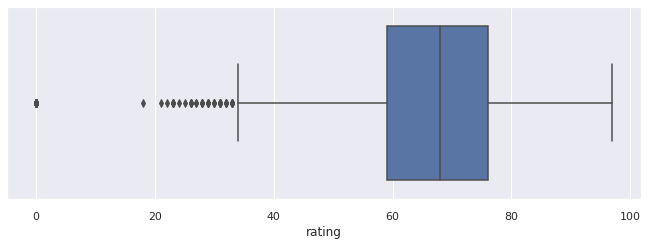

In [22]:
#rating
plt.subplot(3,2,1)
sns.boxplot(df1['rating']);

Com esse gráfico é possível ver que há alguns valores bem abaixo da mediana, mas como eles seriam referentes as notas de filmes/séries, há lógica em eles estarem bem abaixo da mediana, pois é natural que alguns itens da Netflix sejam pior julgados do que outros.

Abaixo será dada uma olhada se a distribuição da variável é normal.

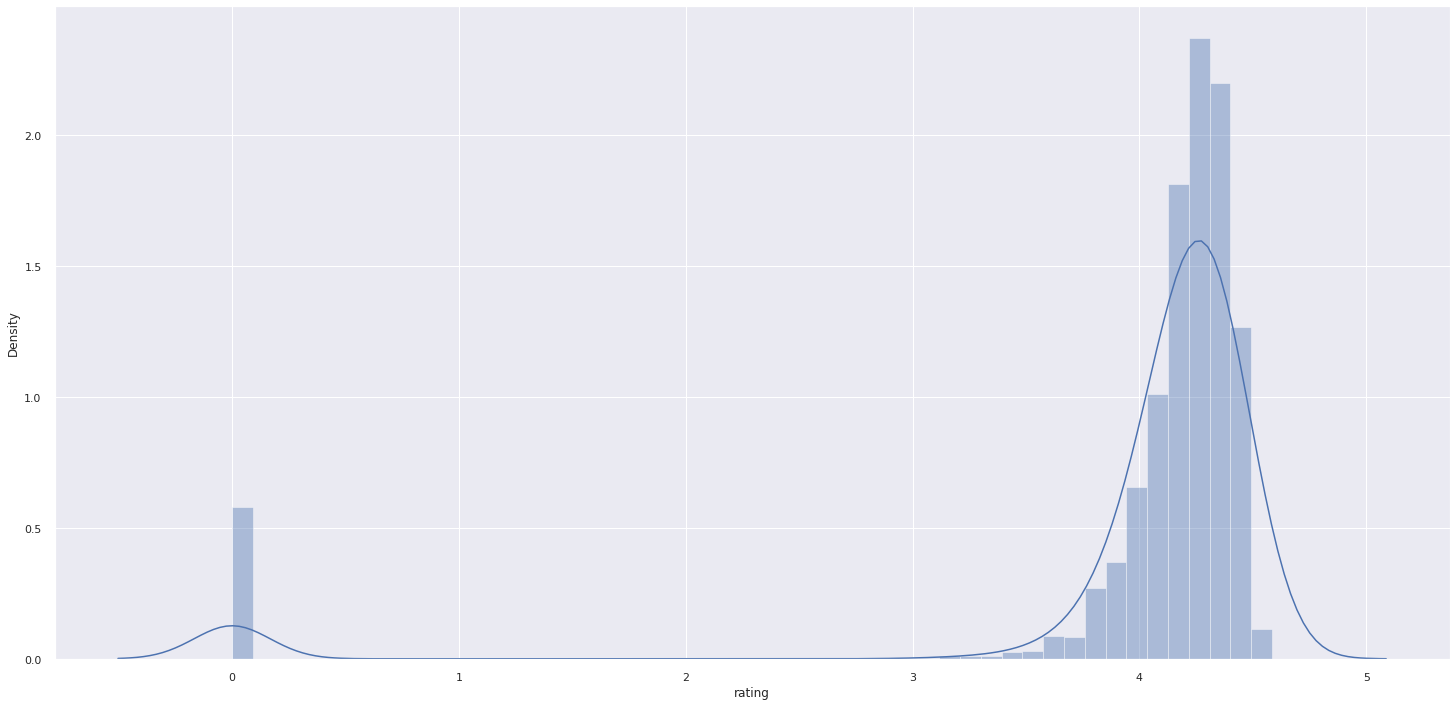

In [23]:
# Rating
sns.distplot(np.log1p(num_attributes['rating']));

Como já visto antes, existem alguns valores bem abaixo da mediana, o que causa uma distruição diferente da normal, mas como é algo que pode ser considerada comum nesse modelo de negócio, eu considero que não há distorção da realidade presente aí.

## 1.8. Categorical Attributes Check 

In [24]:
cat_attributes.apply(lambda x: x.unique().shape[0])

type              2
title          6161
director       3301
cast           5460
country         555
duration        201
listed_in       461
description    6214
dtype: int64

Aqui eu decidi realizar a análise por type e duration. Pois as outras colunas possuem textos que não se repetem e serão devidamente tratadas na parte "2.0. Feature Engineering" e na parte "3.0. Data Filtering", podendo ser analisadas posteriormente de maneira correta.

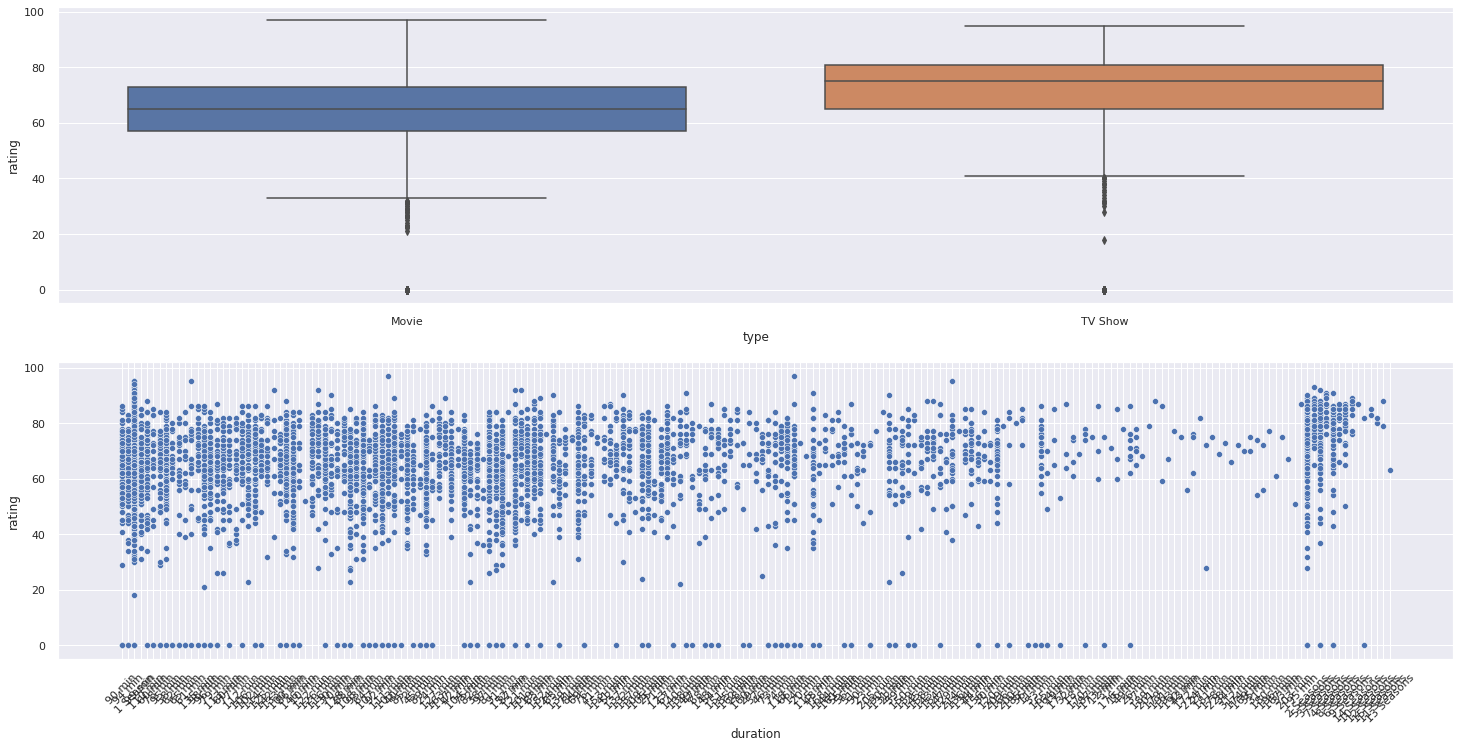

In [25]:
# Checking Outliers By Type
plt.subplot(2, 1, 1)
sns.boxplot(x='type', y='rating', data=df1)

# Checking Outliers By Duration
plt.subplot(2, 1, 2)
sns.scatterplot(x='duration', y='rating', data=df1);
plt.xticks(rotation=45);

Aqui podemos ver que a duração e o tipo não influencia muito na questão de outliers (mesmo que naturais dos dados).

# 2.0. Etapa 02 - Feature Engineering

In [26]:
# copiando o dataframe para torná-lo resetável.
df2 = df1.copy()

## 2.1. Data Cleaning

Foi decidido utilizar técnicas de Regex para realizar a limpeza dos dados, pois regex é capaz de localizar e retornar apenas o que foi pedido.

In [27]:
# aplicando o regex apenas nas seasons para poder calcular o tempo de cada uma em minutos
df2['duration'] = df2['duration'].apply(lambda x: int(re.search('\d+', x).group(0)) if 
                                        x.endswith('Season') | x.endswith('Seasons') else x)

# multiplicando as seasons por 600 x quantidade de seasons, pois 600 é o tempo médio gasto para assistir uma
# season completa.
df2['duration'] = df2['duration'].apply(lambda x: str(600*x) if type(x) == int else x)

# aplicando o regex no resto dos dados para poder usar em análise prévia
df2['duration'] = df2['duration'].apply(lambda x: int(re.search('\d+', x).group(0)))

In [28]:
# renomeando coluna para durantion_min
df2 = df2.rename(columns={'duration':'duration_min'})
df2.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration_min', 'listed_in', 'description'],
      dtype='object')

## 2.2.  Ajustando Variável Resposta

In [29]:
# delimitando variável resposta
df2['rating'] = df2['rating'].apply(lambda x: 10 if (x >= 0) & (x <= 20) else 30 if (x > 20) & (x <= 40)
                                              else 50 if (x > 40) & (x <= 60) else 70 if (x > 60) & (x <= 80)
                                              else 90 if (x > 80) & (x <= 100) else x)

## 2.3. Feature Engineering (Derivando Variáveis)

Aqui estão sendo derivadas todas as variáveis possíveis para poder analisar e compreender melhor o que irá influenciar a nota que os filmes irão receber.

In [30]:
# derivando "number of countries" feature 
#(irei considerar os "none" como 1, pois julgarei que todos os shows foram lançados ao menos em 1 país)
df2['num_of_countries'] = df2['country'].apply(lambda x: 1 + x.count(','))

# derivando "number of cast" feature
df2['num_of_cast'] = df2['cast'].apply(lambda x: 1 + x.count(','))

# derivando "number of directores" feature 
#(1 nos 'not_informed', pois considerarei que um filme/série precisa de ao menos 1 diretor)
df2['num_of_director'] = df2['director'].apply(lambda x: (1 + x.count(',')))

# derivando "num_of_categories" feature
df2['num_of_categories'] = df2['listed_in'].apply(lambda x: 1 + x.count(','))

# derivando "duration_hour" feature
df2['duration_hour'] = df2['duration_min'].apply(lambda x: x/60)

# derivating added_year feature
df2['added_year'] = df2['date_added'].dt.year

# derivando "month_of_year" feature
df2['month_of_year'] = df2['date_added'].dt.month

# derivando "week_of_year" feature
df2['week_of_year'] = df2['date_added'].dt.isocalendar().week

# derivando "day_of_week" feature
df2['day_of_month'] = df2['date_added'].dt.day

# derivando "day_of_week" feature
df2['day_of_week'] = df2['date_added'].dt.dayofweek # Monday = 0, Sunday = 6.

# derivando diferença do ano de lançamento e de adição
df2['diff_bet_years'] = (df2['added_year'] - df2['release_year']).astype(int)

No caso da derivação da diferença entre o ano de lançamento e de adição, os valores negativos poderiam indicar várias coisas, inclusive que os dados estão errados e precisam ser excluídos, mas como já estamos trabalhando com pouco dados, eu decidi optar por seguir o viés de que seria referente a situação do show ter sido adicionado antes do lançamento, pois o ano de lançamento seria referente a lançamento em outras mídias e não a adição na Netflix (no caso, todos os shows dos dados teriam tido esse lançamento).

Para evitar maiores problemas, irei apenas usar essa variável na análise de dados e não no treinamento de algoritmos, uma vez que reconheço que ela iria apresentar um padrão um pouco diferente

## 2.4. Ajustando Variáveis

In [31]:
# ajuste da variável type para snakecase
df2['type'] = df2['type'].apply(lambda x: x.lower().replace(' ', '_').strip())

## 2.5. Mindmap

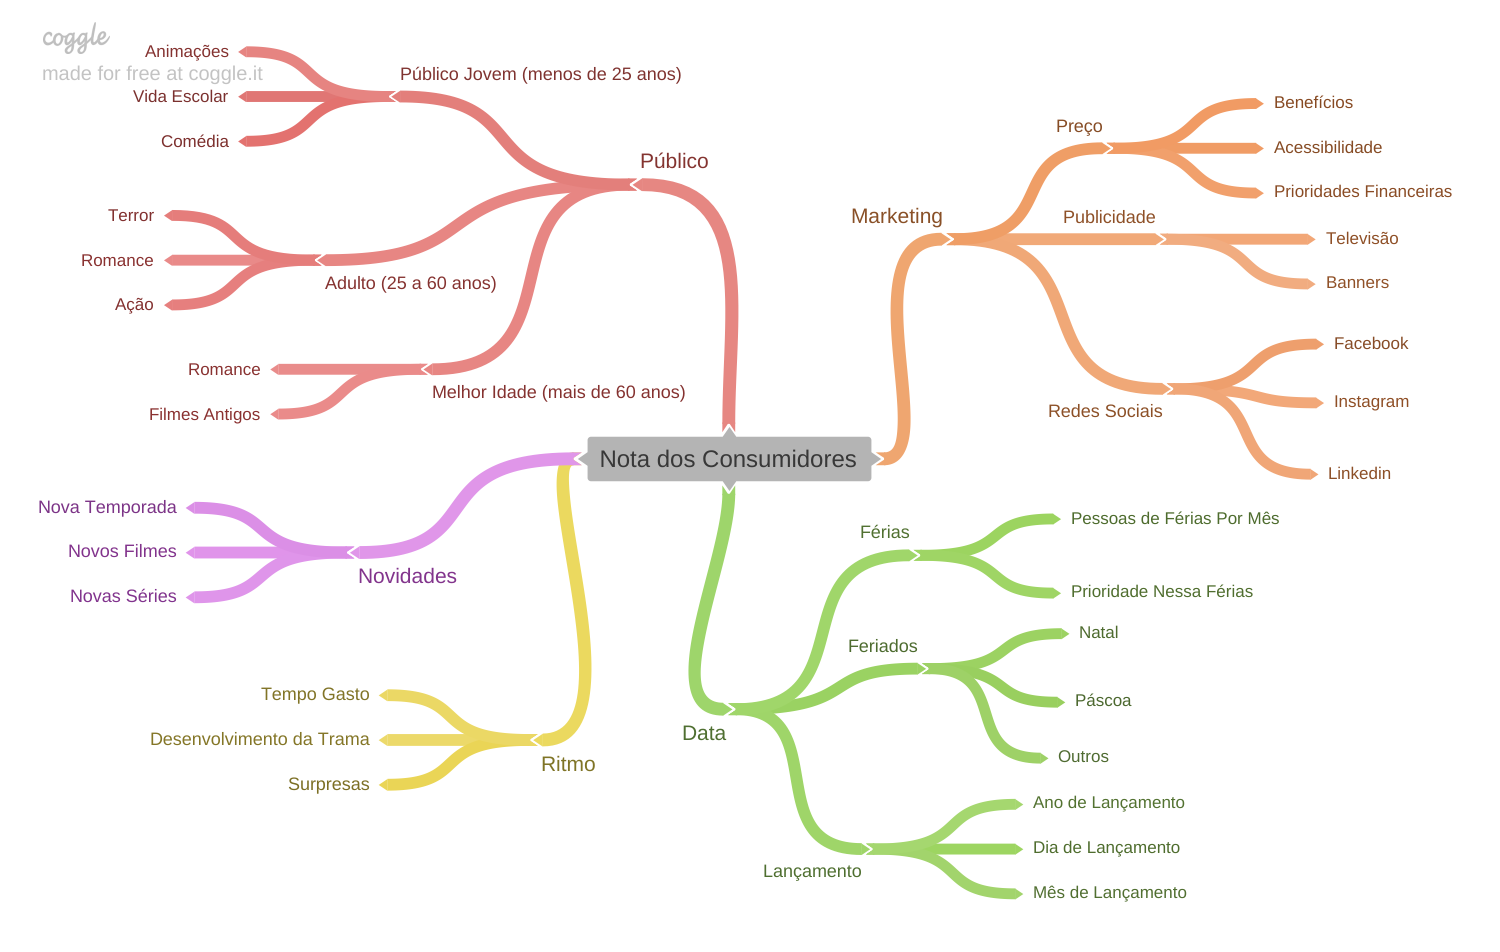

In [32]:
Image('mindmap/mindmap.png')

## 2.6. Lista de Hipoteses

**Essa lista de hipoteses foi feita considerando as features existentes(derivadas e não derivadas) para validação e seleção manual de algumas features que poderem influenciar no modelo de machine learning.**

**H1.** Shows do tipo "TV Show" possuem notas maiores do que os do tipo "Movie" em mediana.

**H2.** Shows com mais diretores possuem notas maiores em mediana.

**H3.** Shows com mais atores possuem notas maiores em mediana.

**H4.** Shows com maior duração possuem notas maiores em mediana.

**H5.** Shows do tipo "TV Show" que possuem mais temporadas (a cada 600 min é uma temporada) possuem melhores notas em mediana.

**H6.** Shows adicionados nos últimos 3 meses do ano possuem maiores notas em mediana.

**H7.** Shows adicionados nas últimas semanas de um ano possuem maiores notas em mediana.

**H8.** Shows adicionados nos sextas, sábados e domingos possuem maiores notas em mediana.

**H9.** Shows adicionados nos últimos 3 anos possuem maiores notas em mediana.

**H10.** Shows lançados (não necessariamente na Netflix) nos últimos 10 anos possuem maiores notas em mediana.

**H11.** Shows adicionados em mais do que 1 categoria possuem rating maior em mediana.

**H12.** Quanto mais países os shows são adicionados, maior serão suas notas em mediana.

**H13.** Mais de 2 anos de diferença entre o ano de lançamento e de adição a Netflix faz com que a nota do show seja menor.

# 3.0. Etapa 03 - Filtragem de Variáveis

In [33]:
# copiando dataframe para poder torná-lo recuperável
df3 = df2.copy()

## 3.1. Filtrando colunas

Aqui serão dropadas as colunas que foram usadas na derivação de novas variáveis e também as colunas "description" e "title", pois como elas não possuem uma padronização muito clara, não é possível para o algoritmo obter aprendizado delas.

Além dessas, também será dropada a coluna "id", pois ela é apenas uma coluna de identificação e não poderá fornecer aprendizado útil para o algoritmo.

In [34]:
# checagem anterior à filtragem
print(df3.shape)
print(df3.columns)

(6222, 23)
Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration_min', 'listed_in', 'description',
       'num_of_countries', 'num_of_cast', 'num_of_director',
       'num_of_categories', 'duration_hour', 'added_year', 'month_of_year',
       'week_of_year', 'day_of_month', 'day_of_week', 'diff_bet_years'],
      dtype='object')


In [35]:
# dropando colunas
df3 = df3.drop(['title', 'show_id', 'director', 'cast', 'country', 'date_added', 
                'description', 'listed_in'], axis=1)

# correcting dtype
df3['week_of_year'] = df3['week_of_year'].astype(int)

In [36]:
# checagem posterior à filtragem
print(df3.shape)
print(df3.columns)

(6222, 15)
Index(['type', 'release_year', 'rating', 'duration_min', 'num_of_countries',
       'num_of_cast', 'num_of_director', 'num_of_categories', 'duration_hour',
       'added_year', 'month_of_year', 'week_of_year', 'day_of_month',
       'day_of_week', 'diff_bet_years'],
      dtype='object')


# 4.0. Etapa 04 - Análise Exploratória de Dados

In [37]:
df4 = df3.copy()

## 4.1. Univariable Analysis

Aqui irei checar a distribuição de todas as features após o feature engineering.

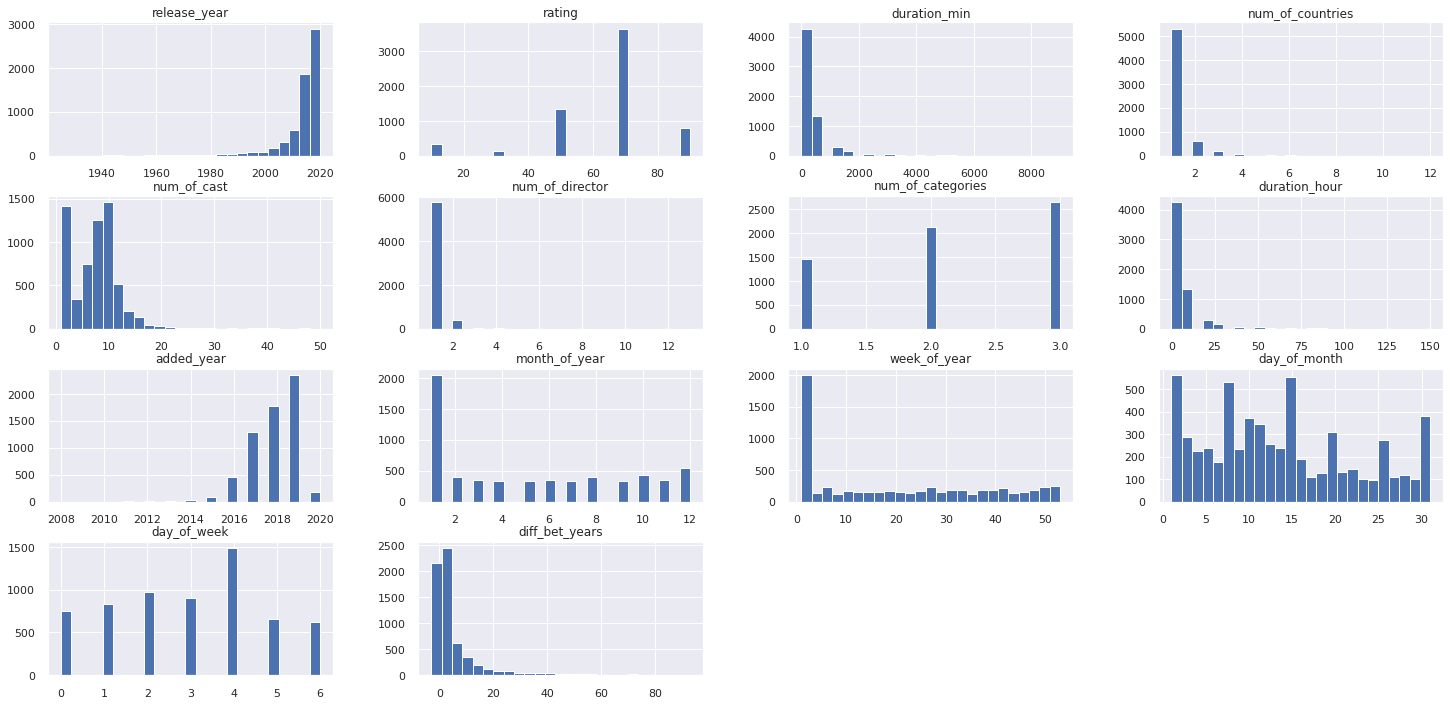

In [38]:
# checking the distribution in all features
df4.hist(bins=25);

Como é possível vermos, a maioria das features não possuem uma distribuição normal, logo é importante trabalharmos nelas depois na parte "5.0. Data Preparation".

## 4.2. Bivariable Data Analysis (Validação de Hipóteses)

Nessa parte, estará sendo tratada a validação das hipóteses de negócio listadas anteriormente na parte "**2.5. Lista de Hipoteses**" e em algumas dessas hipóteses ocorrerá a presença de **insights** que serão informações extraídas dos dados que quebram conceitos pré-formados anteriormente pela empresa e pode de imediato ajudá-la a se tornar mais eficiente.

### **H1.** Shows do tipo "TV Show" possuem notas maiores do que os do tipo "Movie" em mediana.
**VERDADEIRO** "TV Shows" possuem maiores notas em mediana do que os "movies".

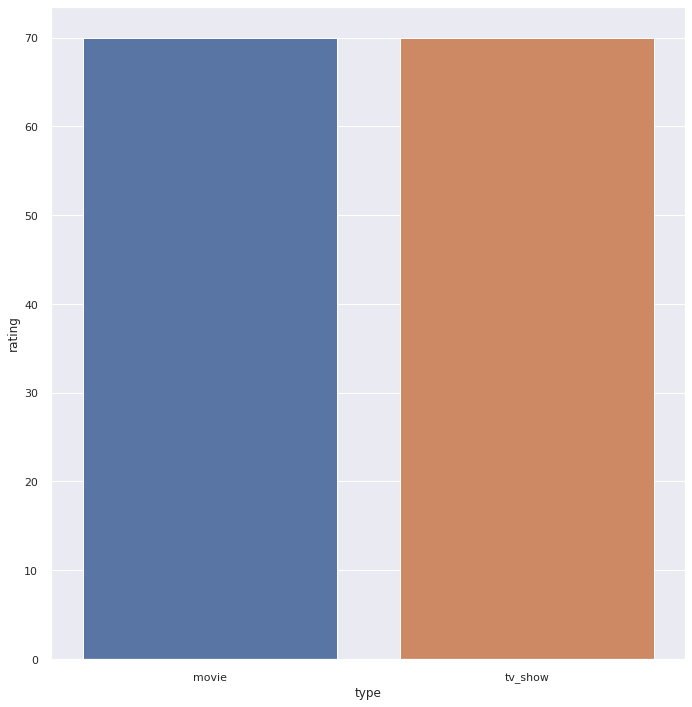

In [39]:
# agrupando por os rating por tipo
aux1 = df4[['rating', 'type']].groupby('type').median().reset_index()

# plotando o gráfico
plt.subplot(1, 2, 1)
sns.barplot(x='type', y='rating', data=aux1);

### **H2.** Shows com mais diretores possuem notas maiores em mediana. (INSIGHT)
**FALSO** Shows com mais diretores possuem notas menores em mediana.

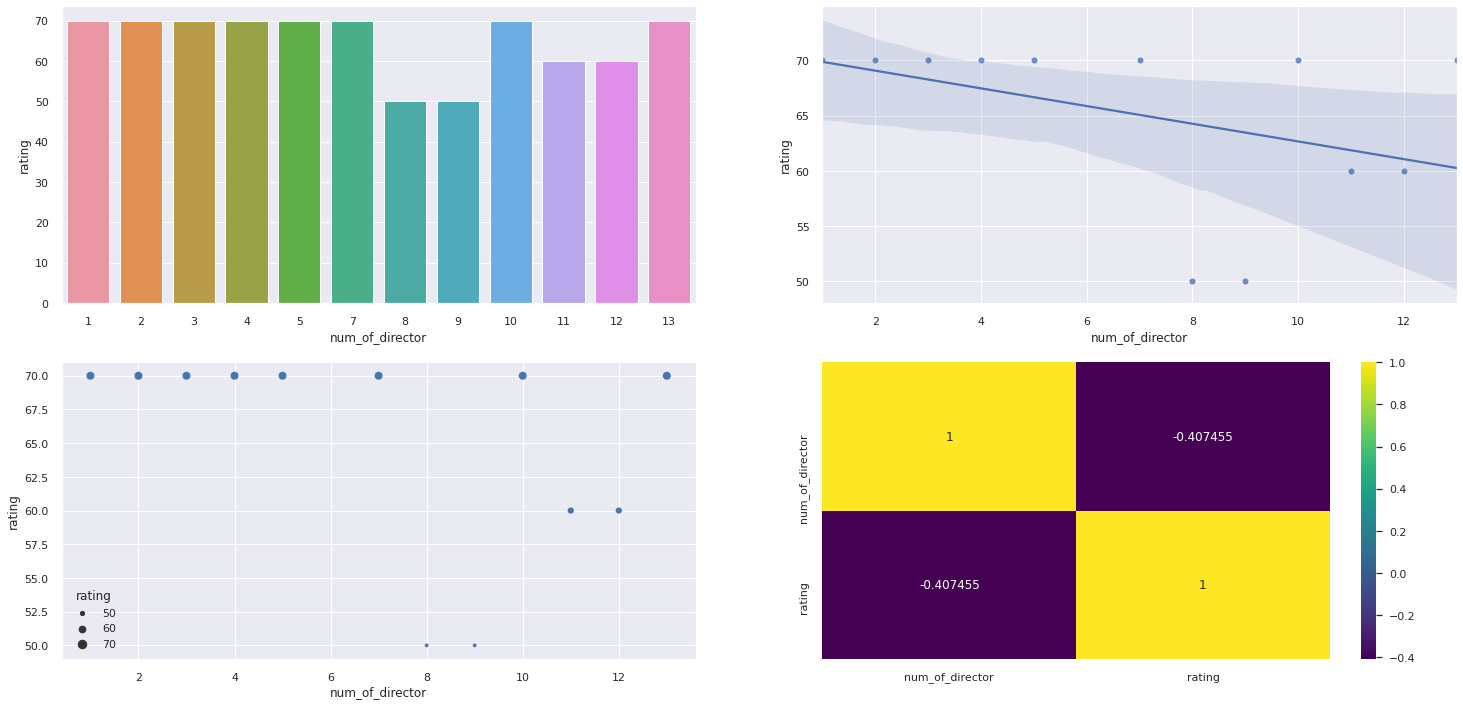

In [40]:
# agrupando por os rating pelo número de diretores
aux1 = df4[['rating', 'num_of_director']].groupby('num_of_director').median().reset_index()

# plotando o gráfico de barras
plt.subplot(2, 2, 1)
sns.barplot(x='num_of_director', y='rating', data=aux1);

# plotando o gráfico de reg
plt.subplot(2, 2, 2)
sns.regplot(x='num_of_director', y='rating', data=aux1);

# plotando o gráfico de reg
plt.subplot(2, 2, 3)
sns.scatterplot(x='num_of_director', y='rating', size='rating', data=aux1);

# plotando o gráfico de correlação
plt.subplot(2, 2, 4)
sns.heatmap(aux1.corr(method='pearson'), annot=True, fmt="g", cmap='viridis');

Com esse insight será possível a Netflix começar a repensar sobre a quantidade de diretores que um show realmente precisa, talvez até utilizando menos diretores em alguns shows e poupando certo valor de investimento que seria usado nesses diretores extras. Além de aumentar sua quantidade de visualizações por estar tendo obras sendo melhor avaliadas.

### **H3.** Shows com mais atores possuem notas maiores em mediana.
**VERDADEIRO** Shows com mais atores possuem notas maiores em median.

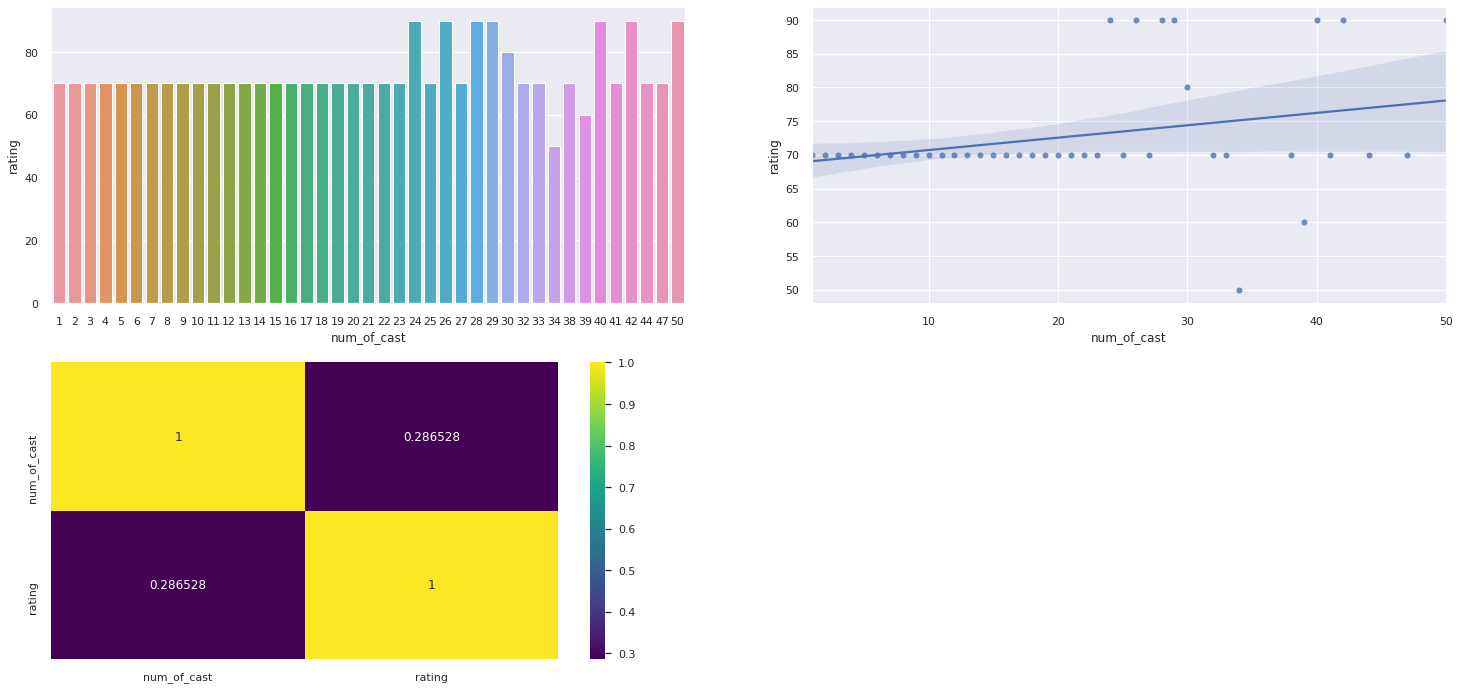

In [41]:
# agrupando por os rating pelo número de atores
aux1 = df4[['rating', 'num_of_cast']].groupby('num_of_cast').median().reset_index()

# plotando o gráfico de barras
plt.subplot(2, 2, 1)
sns.barplot(x='num_of_cast', y='rating', data=aux1);

# plotando o gráfico de reg
plt.subplot(2, 2, 2)
sns.regplot(x='num_of_cast', y='rating', data=aux1);

# plotando o gráfico de correlação
plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, fmt="g", cmap='viridis');

### **H4.** Shows com maior duração possuem notas maiores em mediana.
**VERDADEIRO** Shows com maior tempo de duração possuem notas maiores em mediana.

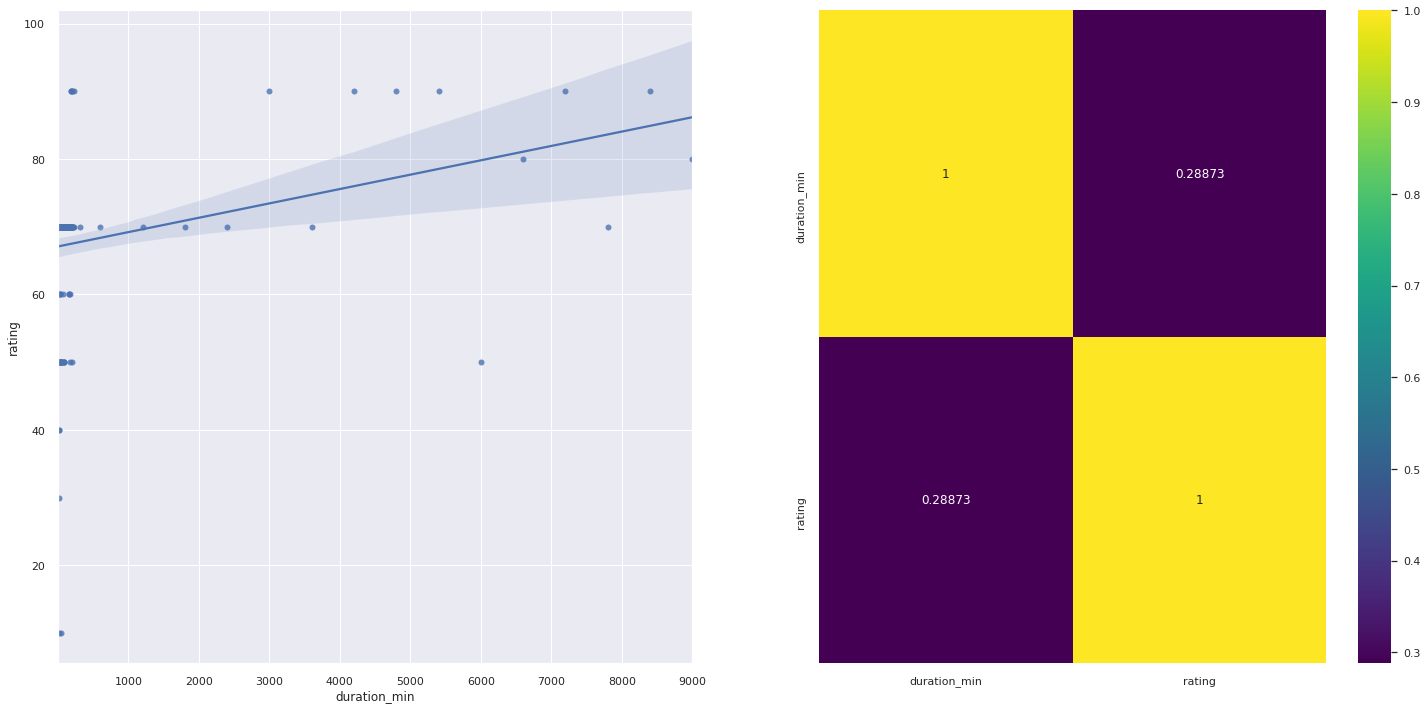

In [42]:
# agrupando por os rating pela duração em minutos
aux1 = df4[['rating', 'duration_min']].groupby('duration_min').median().reset_index()

# plotando o gráfico de reg
plt.subplot(1, 2, 1)
sns.regplot(x='duration_min', y='rating', data=aux1);

# plotando o gráfico de correlação
plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True, fmt="g", cmap='viridis');

### **H5.** Shows do tipo "TV Show" que possuem mais temporadas (a cada 600 min é uma temporada) possuem melhores notas em mediana.
**VERDADEIRO** Shows com uma quantidade maior de temporadas possui notas maiores em mediana.

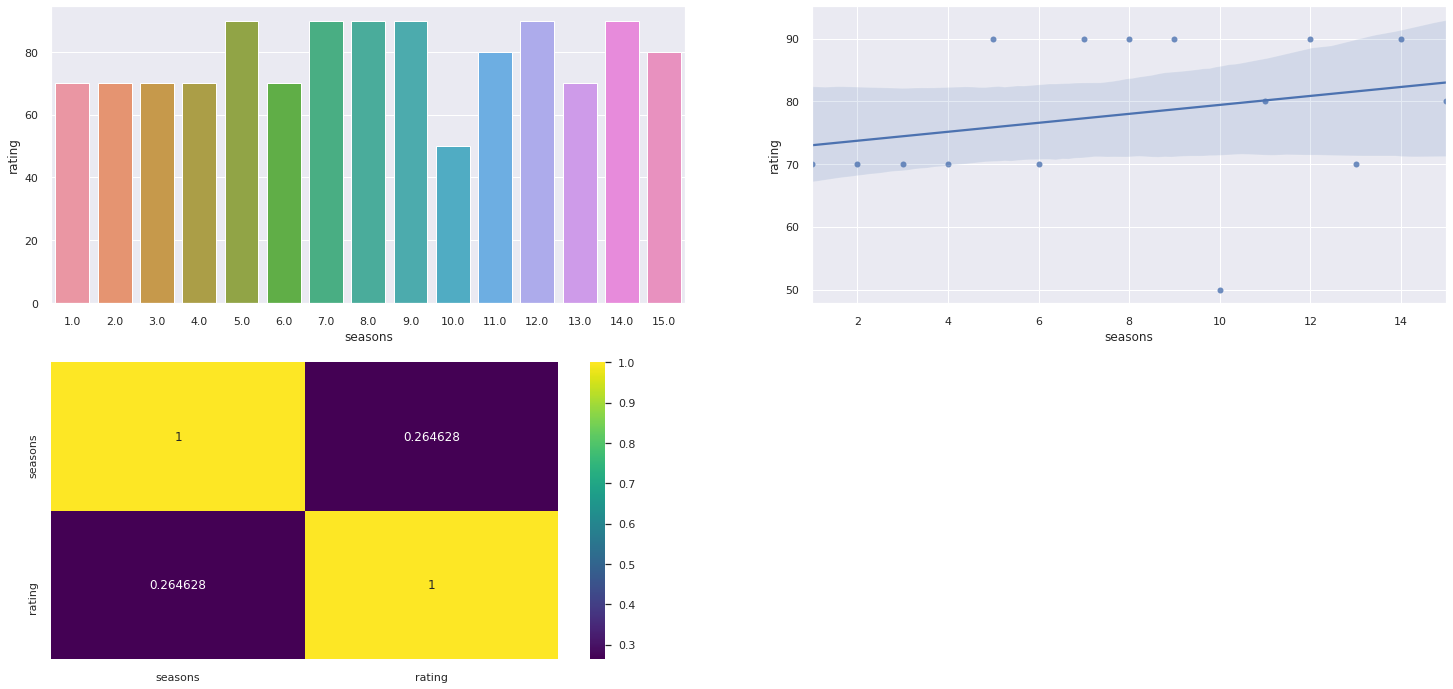

In [43]:
# restrigindo e criando variável com seasons
temp1 = df4[(df4['type'] == 'tv_show')]
temp1['duration_min'] = temp1['duration_min'].apply(lambda x: x/600)
temp1 = temp1.rename(columns={'duration_min':'seasons'})

# agrupando por quantidade de temporadas
aux1 = temp1[['rating', 'seasons']].groupby('seasons').median().reset_index()

# plotando o gráfico de barras
plt.subplot(2, 2, 1)
sns.barplot(x='seasons', y='rating', data=aux1);

# plotando o gráfico de reg
plt.subplot(2, 2, 2)
sns.regplot(x='seasons', y='rating', data=aux1);

# plotando o gráfico de correlação
plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, fmt="g", cmap='viridis');

### **H6.** Shows adicionados nos últimos 3 meses do ano possuem maiores notas em mediana. (INSIGHT)
**FALSO** O ano em geral mantém um certo equilibrio na questão de rating e no final dele, há até mesmo uma pequena queda nos ratings. Inclusive, é visível que no início dos anos, há um certo aumento nos ratings.

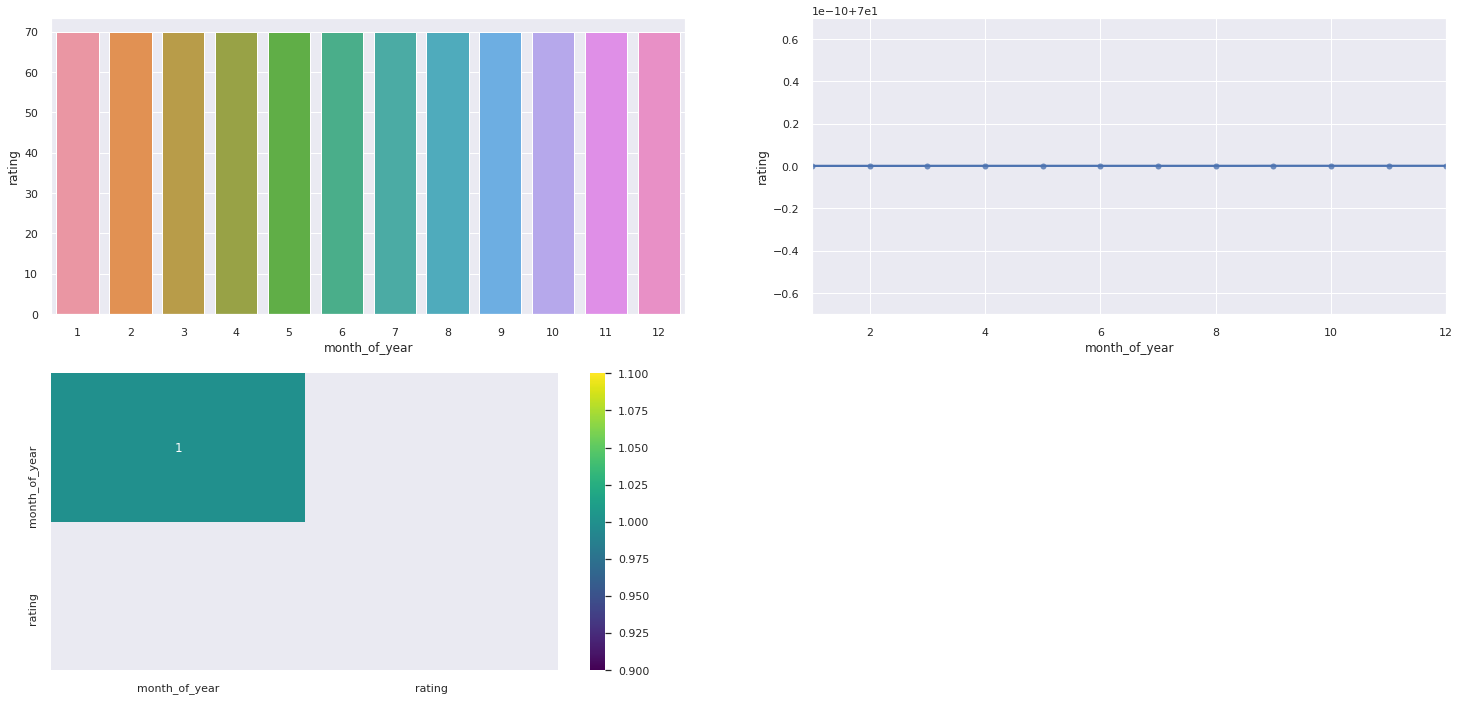

In [44]:
# agrupando por mês do ano
aux1 = df4[['rating', 'month_of_year']].groupby('month_of_year').median().reset_index()

# plotando o gráfico de barras
plt.subplot(2, 2, 1)
sns.barplot(x='month_of_year', y='rating', data=aux1);

# plotando o gráfico de reg
plt.subplot(2, 2, 2)
sns.regplot(x='month_of_year', y='rating', data=aux1);

# plotando o gráfico de correlação
plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, fmt="g", cmap='viridis');

Com esse insight será possível a Netflix poupar mais tempo quando for realizar o planejamento de em qual mês uma obra deve ser lançada, uma vez que os dados demonstram que há uma certo equilibrio em todos os meses quanto ao rating.

### **H7.** Shows adicionados nas últimas semanas de um ano possuem maiores notas em mediana.
**FALSO** Shows adicionados nas últimas semanas do ano, possuem um rating menor em mediana.

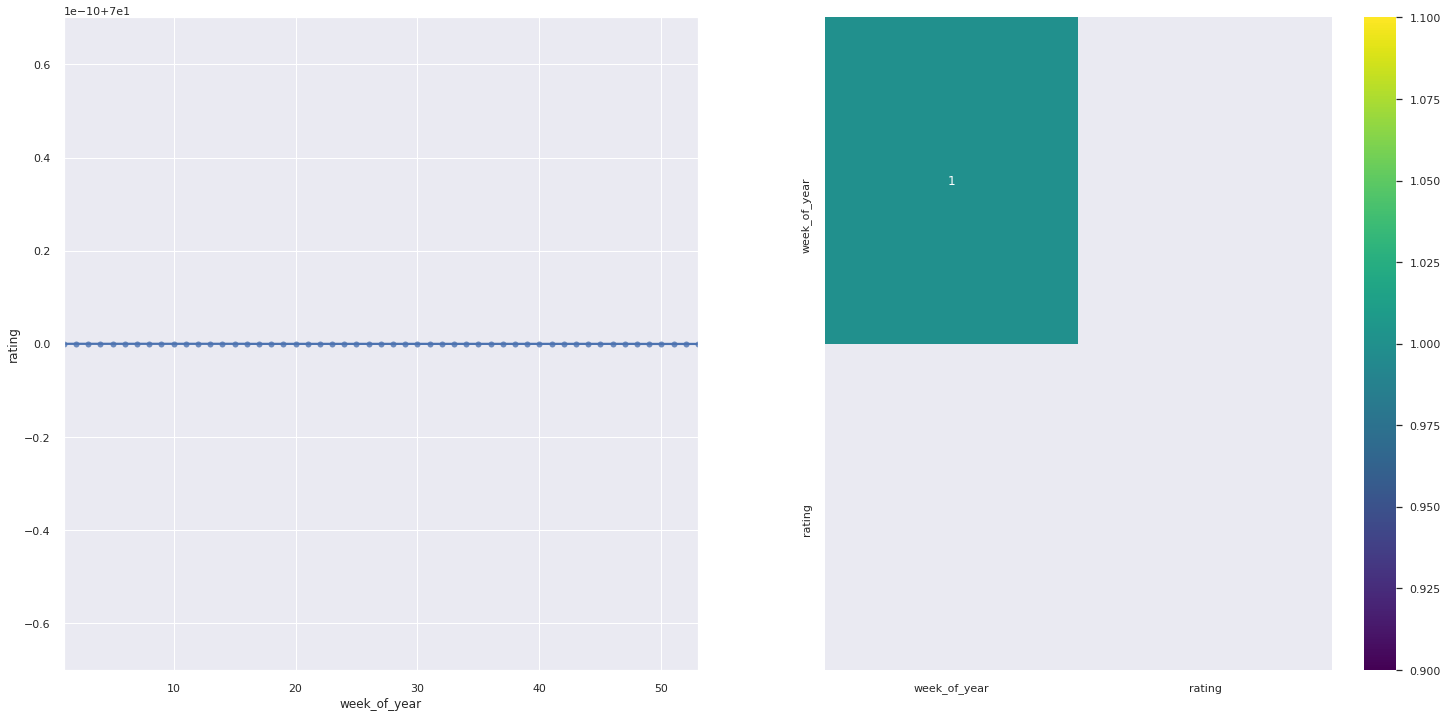

In [45]:
# agrupando por mês do ano
aux1 = df4[['rating', 'week_of_year']].groupby('week_of_year').median().reset_index()

# plotando o gráfico de reg
plt.subplot(1, 2, 1)
sns.regplot(x='week_of_year', y='rating', data=aux1);

# plotando o gráfico de correlação
plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True, fmt="g", cmap='viridis');

### **H8.** Shows adicionados nas sextas, sábados e domingos possuem maiores notas em mediana. (INSIGHT)
**VERDADEIRO** Shows adicionados nas sextas, sábados e domingos possuem notas maiores em mediana do que em outros dias da semana.

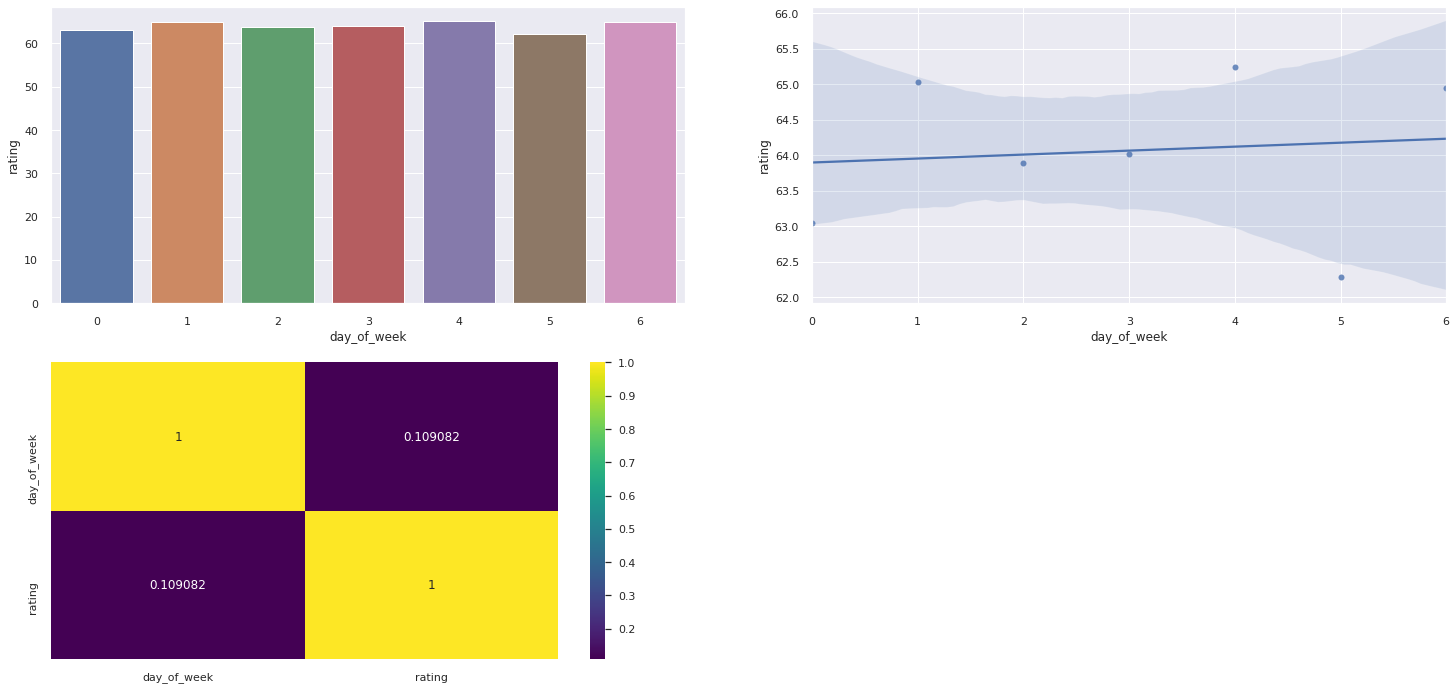

In [46]:
# agrupando por dia da semana (Monday = 0, Sunday = 6).
aux1 = df4[['rating', 'day_of_week']].groupby('day_of_week').mean().reset_index()

# plotando o gráfico de barras
plt.subplot(2, 2, 1)
sns.barplot(x='day_of_week', y='rating', data=aux1);

# plotando o gráfico de reg
plt.subplot(2, 2, 2)
sns.regplot(x='day_of_week', y='rating', data=aux1);

# plotando o gráfico de correlação
plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, fmt="g", cmap='viridis');

Com esse insight será possível a Netflix se planejar melhor quanto à data de quando os shows devem ser lançados, os lançando geralmente aos finais de semana (sextas, sábados e domingos).

### **H9.** Shows adicionados nos últimos 3 anos possuem maiores notas em mediana. (INSIGHT)
**FALSO** Embora tenha havido uma queda nos anos de 2009 e 2010, nos anos de 2011 a 2017, foi mantido um valor regular e algumas vezes até maior do que nos últimos 3 anos analisados (2018 a 2020).

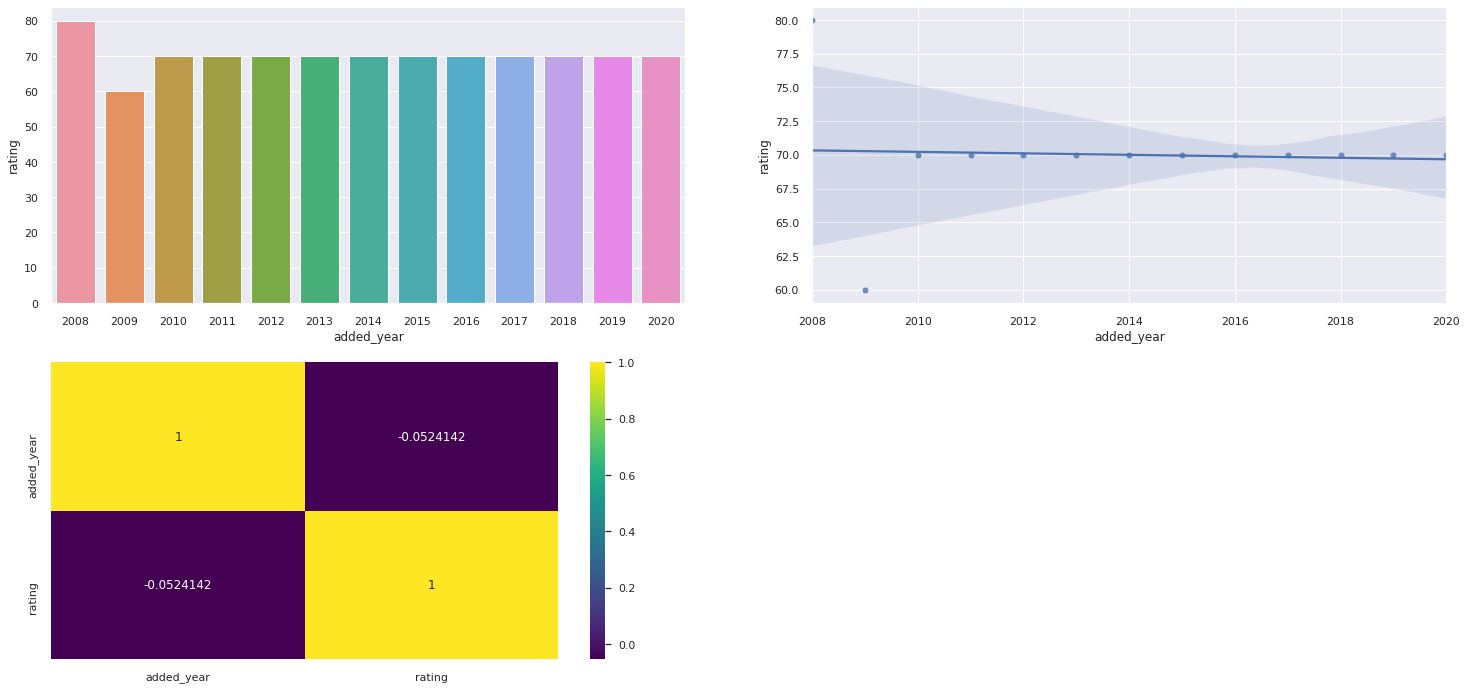

In [47]:
# agrupando por ano de adição.
aux1 = df4[['rating', 'added_year']].groupby('added_year').median().reset_index()

# plotando o gráfico de barras
plt.subplot(2, 2, 1)
sns.barplot(x='added_year', y='rating', data=aux1);

# plotando o gráfico de reg
plt.subplot(2, 2, 2)
sns.regplot(x='added_year', y='rating', data=aux1);

# plotando o gráfico de correlação
plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, fmt="g", cmap='viridis');

Com esse insight será possível a Netflix poupar certo investimento em produzir mais shows e adicionar na Netflix e estar começando a divulgar mais shows lançados anteriormente que pelo visto atraiam um maior agrado do público em mediana.

### **H10.** Shows lançados (não necessariamente na Netflix) nos últimos 10 anos possuem maiores notas em mediana.
**FALSO** Shows lançados antigamente possuem notas maiores em mediana do que os lançados nos últimos 10 anos.

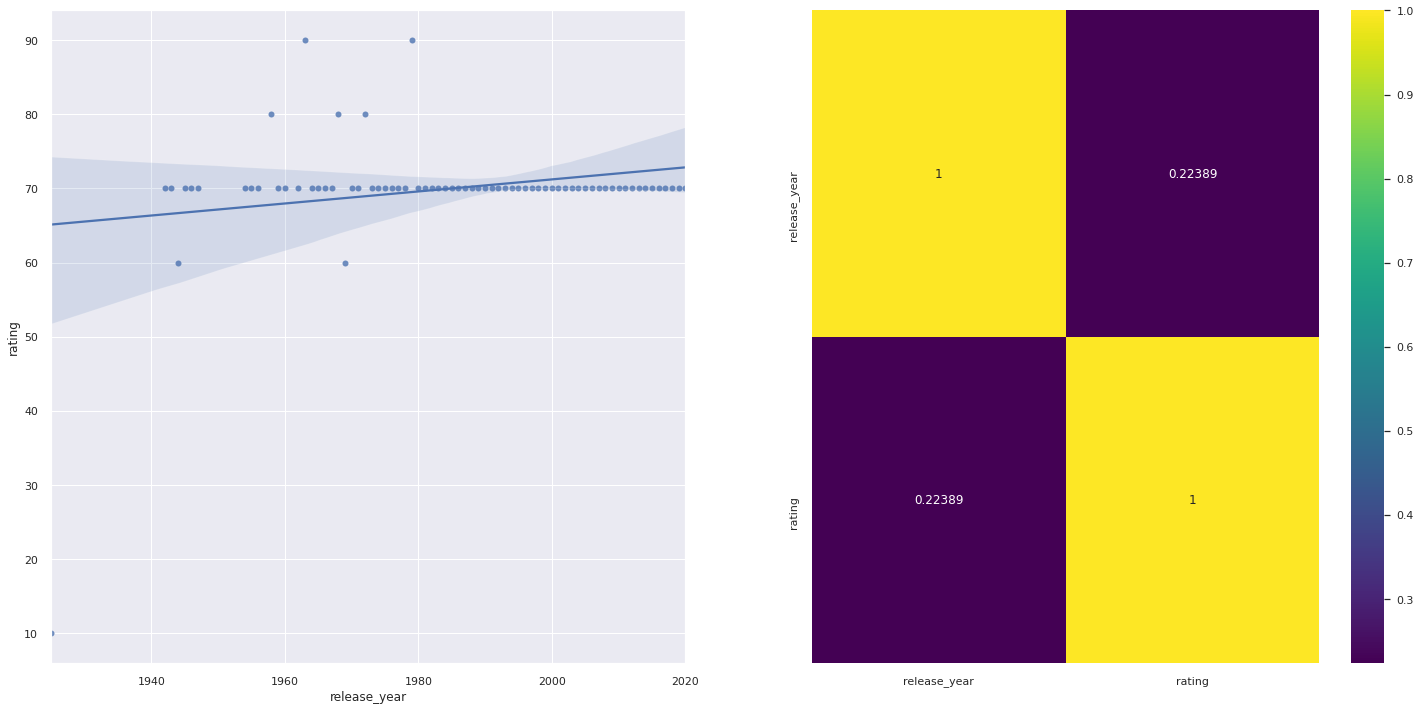

In [48]:
# agrupando por ano de lançamento.
aux1 = df4[['rating', 'release_year']].groupby('release_year').median().reset_index()

# plotando o gráfico de reg
plt.subplot(1, 2, 1)
sns.regplot(x='release_year', y='rating', data=aux1);

# plotando o gráfico de correlação
plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True, fmt="g", cmap='viridis');

### **H11.** Shows adicionados em mais do que 1 categoria possuem rating maior em mediana.
**VERDADEIRO** Embora aquele adicionados em apenas 2 categorias não tenham grande diferença, aqueles adicionados em 3 categorias tem um bom aumento no rating em mediana.

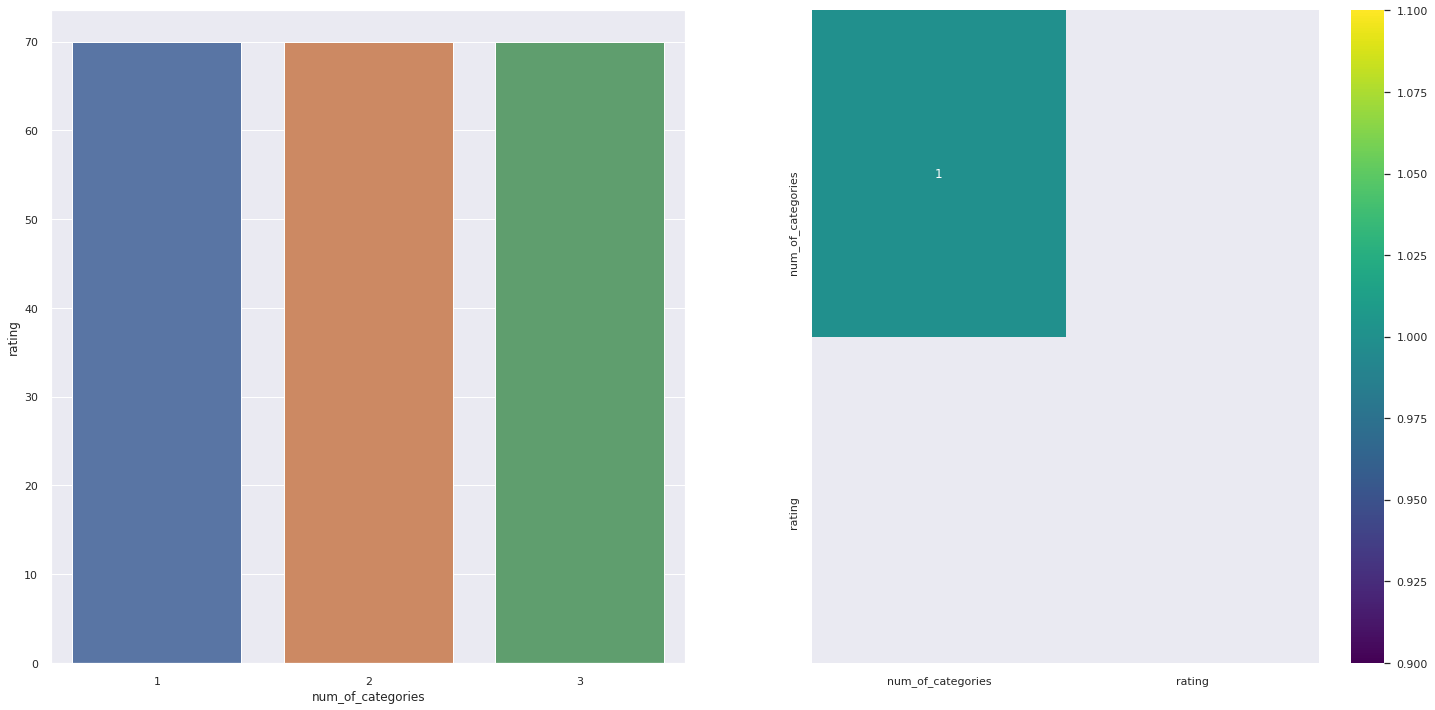

In [49]:
# agrupando por quantidade de categorias adicionadas.
aux1 = df4[['rating', 'num_of_categories']].groupby('num_of_categories').median().reset_index()

# plotando o gráfico de reg
plt.subplot(1, 2, 1)
sns.barplot(x='num_of_categories', y='rating', data=aux1);

# plotando o gráfico de correlação
plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True, fmt="g", cmap='viridis');

### **H12.** Quanto mais países os shows são adicionados, maior serão suas notas em mediana. (INSIGHT)
**FALSO** Embora o gráfico de correlação indique um aumento de acordo com o aumento no número de países, na realidade, isso foi algo pontual na quantidade de 10 países, as outras notas a partir de 6 países são menores do que os com menos países.

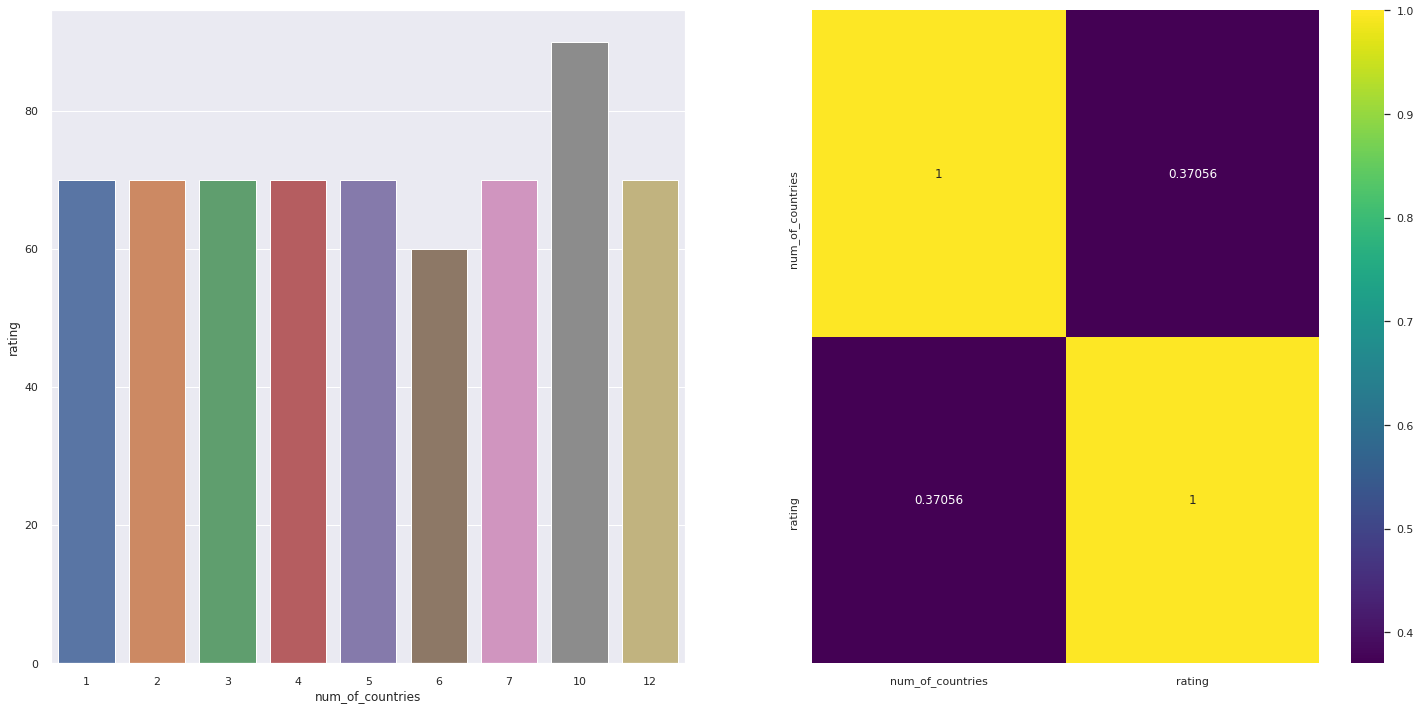

In [50]:
# agrupando pelo número de países em que foram lançados
aux1 = df4[['rating', 'num_of_countries']].groupby('num_of_countries').median().reset_index()

# plotando o gráfico de reg
plt.subplot(1, 2, 1)
sns.barplot(x='num_of_countries', y='rating', data=aux1);

# plotando o gráfico de correlação
plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True, fmt="g", cmap='viridis');

Esse insight indica que o ideal é que a Netflix faça um estudo bem detalhado sobre quais países realmente precisa divulgar seus shows, pois é visível que há um certo decréscimo em mediana em shows que estão presentes em mais países. Claro, o país em específico também é importante de ser analisado.

### **H13.** Mais de 2 anos de diferença entre o ano de lançamento e de adição a Netflix faz com que a nota do show seja menor. (INSIGHT)
**FALSO** Mesmo após 2 anos de lançamento, caso lançado na Netflix, a série ainda tem uma audiência média, em alguns casos, até aumenta.

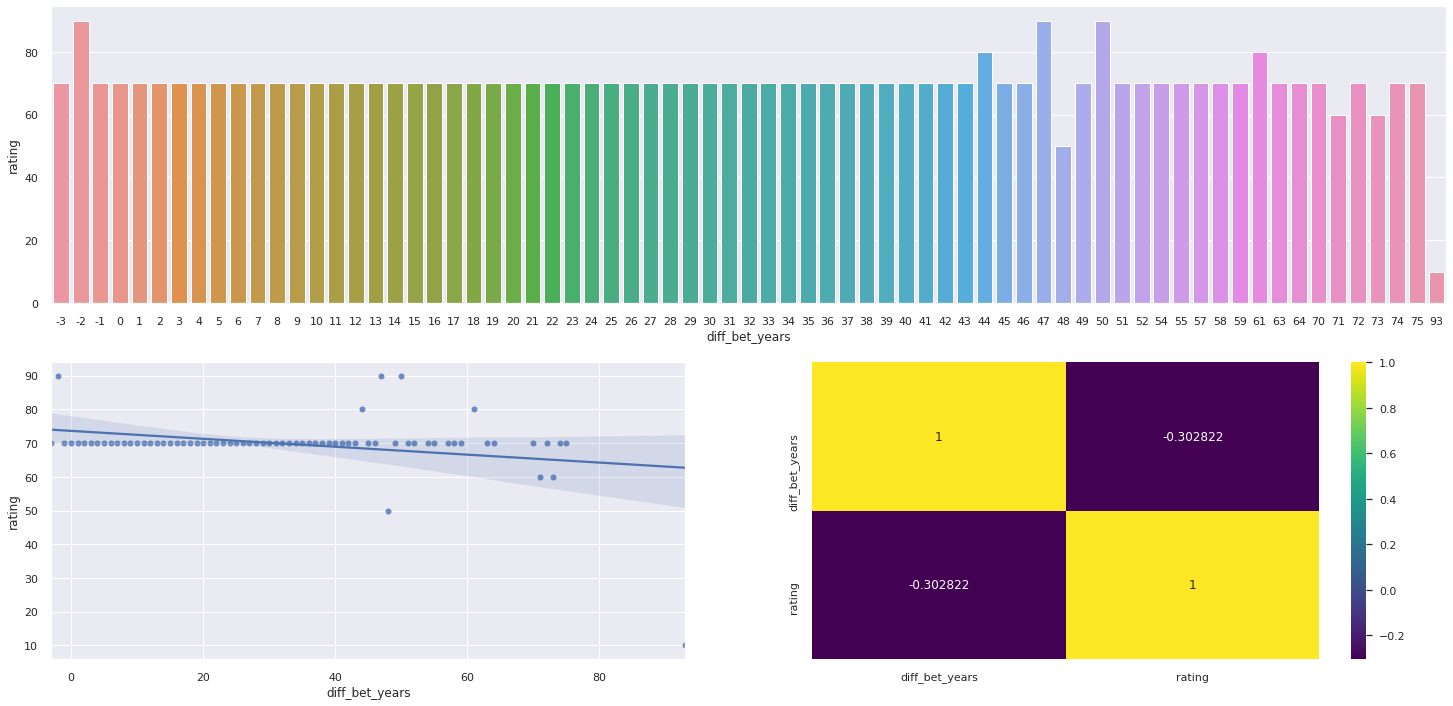

In [51]:
# agrupando pela quantidade de anos de diferença entre o lançamento e a adição
aux1 = df4[['rating', 'diff_bet_years']].groupby('diff_bet_years').median().reset_index()

# plotando o gráfico de reg
plt.subplot(2, 2, 3)
sns.regplot(x='diff_bet_years', y='rating', data=aux1);

# plotando o gráfico de barras
plt.subplot(2, 1, 1)
sns.barplot(x='diff_bet_years', y='rating', data=aux1);

# plotando o gráfico de correlação
plt.subplot(2, 2, 4)
sns.heatmap(aux1.corr(method='pearson'), annot=True, fmt="g", cmap='viridis');

Esse insight demonstra que a Netflix pode estar obtendo shows sem se preocupar com o fato deles terem sido lançados a muitos anos atrás, pois shows mais antigos pode até mesmo ter notas melhores do que os mais atuais.

## 4.3. Multivariable Data Analysis

Aqui foi plotado o gráfico de correlação completo com todas as correlações para ser possível realizar uma análise completa de todas as variáveis (com exceção da "type" que é uma variável categorica, mas que será considerada, pois, de acordo com o que foi explorado, ela é relevante).

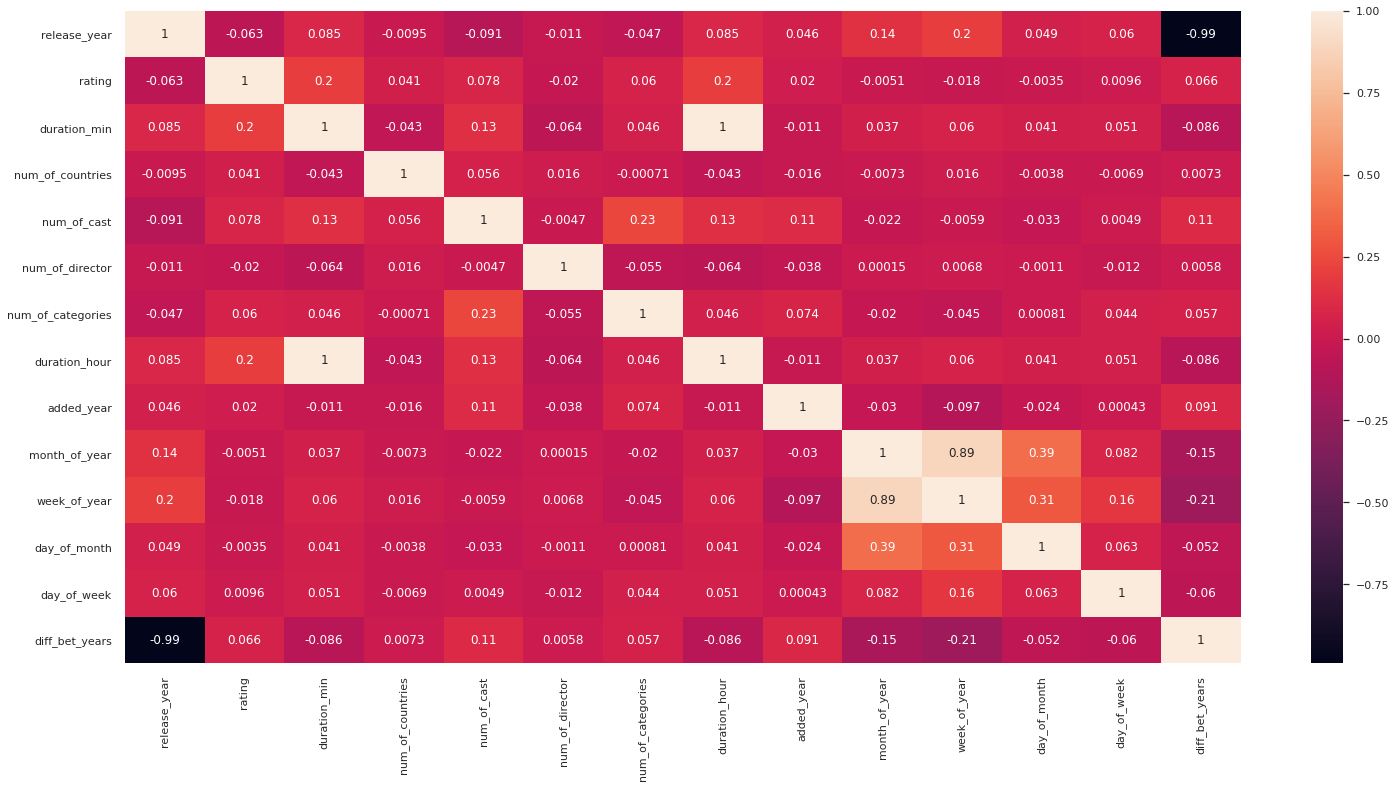

In [52]:
correlation = df4.corr(method='pearson')
sns.heatmap(correlation, annot=True);

## 4.4. Resumo das Hipoteses

In [53]:
tab = [['Hipoteses', 'Conclusão', 'Relevância'],
       ['H1', 'Verdadeira', 'Alta'],
       ['H2', 'Falsa', 'Baixa'],
       ['H3', 'Verdadeira', 'Média'],
       ['H4', 'Verdadeira', 'Média'],
       ['H5', 'Verdadeira', 'Baixa'],
       ['H6', 'Falsa', 'Média'],
       ['H7', 'Falsa', 'Baixa'],
       ['H8', 'Verdadeira', 'Alta'],
       ['H9', 'Verdadeira', 'Média'],
       ['H10', 'Verdadeira', 'Média'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Falsa', 'Baixa'],
       ['H13', 'Falsa', 'Média']]
print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Verdadeira   Alta
H2           Falsa        Baixa
H3           Verdadeira   Média
H4           Verdadeira   Média
H5           Verdadeira   Baixa
H6           Falsa        Média
H7           Falsa        Baixa
H8           Verdadeira   Alta
H9           Verdadeira   Média
H10          Verdadeira   Média
H11          Verdadeira   Alta
H12          Falsa        Baixa
H13          Falsa        Média


## 4.5. Seleção Manual de Features

In [54]:
# features escolhidas de acordo com análise exploratória de dados
manual = ['type', 
          'release_year',
          'num_of_cast', 
          'duration_min',
          'duration_hour', 
          'month_of_year',
          'day_of_week', 
          'added_year', 
          'num_of_categories',
          'num_of_countries',
          'day_of_month',
          'diff_bet_years']

# 5.0. Etapa 05 - Data Preparation

In [55]:
# copiando para tornar reiniciável o valor
df5 = df4.copy()

## 5.1. Rescaling

Como os valores não estão muito esparsados, mas sim bem organizados, estarei optando por realizar o StandardScaler nas variáveis derivadas de datas e o MinMaxScaler nas demais.

Porém, há duas variáveis que são "duration_min" e a "duration_hour" que serão escaladas com o RobustScaler.

In [56]:
# definindo os scalers
ss = StandardScaler()
mms = MinMaxScaler() 
rs = RobustScaler()

In [57]:
# ----------------------------------STANDARDSCALER----------------------------------------

# release_year => Standard
df5['release_year'] = ss.fit_transform(df5[['release_year']].values)
pickle.dump(ss, open('scalers/release_year_scaler.pkl', 'wb'))

# day_of_month => Standard
df5['day_of_month'] = ss.fit_transform(df5[['day_of_month']].values)
pickle.dump(ss, open('scalers/day_of_month_scaler.pkl', 'wb'))

# day_of_week => Standard
df5['day_of_week'] = ss.fit_transform(df5[['day_of_week']].values)
pickle.dump(ss, open('scalers/day_of_week_scaler.pkl', 'wb'))

# added_year => Standard
df5['added_year'] = ss.fit_transform(df5[['added_year']].values)
pickle.dump(ss, open('scalers/added_year_scaler.pkl', 'wb'))

# month_of_year => Standard
df5['month_of_year'] = ss.fit_transform(df5[['month_of_year']].values)
pickle.dump(ss, open('scalers/month_of_year_scaler.pkl', 'wb'))

# week_of_year => Standard
df5['week_of_year'] = ss.fit_transform(df5[['week_of_year']].values)
pickle.dump(ss, open('scalers/week_of_year_scaler.pkl', 'wb'))

# ----------------------------------ROBUSTSCALER----------------------------------------

# duration_min => Robust
df5['duration_min'] = rs.fit_transform(df5[['duration_min']].values)
pickle.dump(rs, open('scalers/duration_min_scaler.pkl', 'wb'))

# duration_hour => Robust
df5['duration_hour'] = rs.fit_transform(df5[['duration_hour']].values)
pickle.dump(rs, open('scalers/duration_hour_scaler.pkl', 'wb'))

# ----------------------------------MINMAXSCALER----------------------------------------

# diff_bet_years => MinMax
df5['diff_bet_years'] = mms.fit_transform(df5[['diff_bet_years']].values)
pickle.dump(mms, open('scalers/diff_bet_years_scaler.pkl', 'wb'))

# num_of_countries => MinMax
df5['num_of_countries'] = mms.fit_transform(df5[['num_of_countries']].values)
pickle.dump(mms, open('scalers/num_of_countries_scaler.pkl', 'wb'))

# num_of_cast => MinMax
df5['num_of_cast'] = mms.fit_transform(df5[['num_of_cast']].values)
pickle.dump(mms, open('scalers/num_of_cast_scaler.pkl', 'wb'))

# num_of_director => MinMax
df5['num_of_director'] = mms.fit_transform(df5[['num_of_director']].values)
pickle.dump(mms, open('scalers/num_of_director_scaler.pkl', 'wb'))

# num_of_categories => MinMax
df5['num_of_categories'] = mms.fit_transform(df5[['num_of_categories']].values)
pickle.dump(mms, open('scalers/num_of_categories_scaler.pkl', 'wb'))

## 5.2. Encoding

Estou optando por utilizar esse método, pois a máquina consegue compreender bem linguagem binária (uma vez que é sua linguagem original). Desse modo, conseguindo ter uma melhor performance nesse projeto.

In [58]:
# obtendo as dummies
df5 = pd.get_dummies(df5, prefix=['type'], columns=['type'])

## 5.3. Transformation

### 5.3.1. Nature Transformation

Transformação da natureza das variáveis para poder gerar possível que o algoritmo identifique o ciclo, fazendo com que o algoritmo seja capaz de compreender a proximidade entre os meses, a exemplo dele poder perceber que o mês 12 de um ano é próximo do mês 1 do ano seguinte.

Desse modo, as variáveis serão transformadas em seno e cosseno que combinadas representaram a natureza ciclica desses dados.

In [59]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

# day_of_month
df5['day_of_month_sin'] = df5['day_of_month'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df5['day_of_month_cos'] = df5['day_of_month'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

# month_of_year
df5['month_of_year_sin'] = df5['month_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df5['month_of_year_cos'] = df5['month_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

# 6.0. Etapa 06 - Feature Selection

## 6.1. Spliting Dataset in Train and Test

In [60]:
#target variable and features split 
X = df5.drop(columns = 'rating',axis = 1)
y = df5['rating']

#train test split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

## 6.2. Random Forest As Feature Selector (Feature Importance)

Estou usando o Random Forest para poder compreender quais as features mais importantes no dataset.

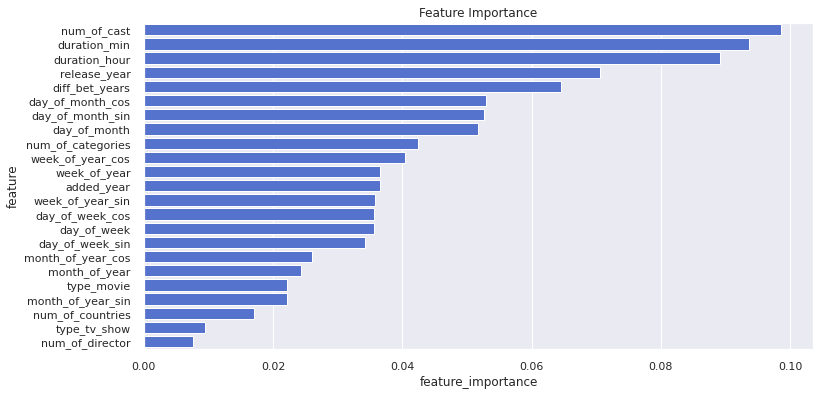

In [61]:
# train random forest classifier
rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
rf.fit(X, y)

# feature importance data frame
feat_sel = pd.DataFrame({'feature': X.columns,
                        'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)


# plot feature importance
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_sel, orient='h', color='royalblue')\
            .set_title('Feature Importance');

In [62]:
# Selecionando as 18 melhores features
feat_sel_columns = feat_sel.iloc[:16]

Aqui está sendo obitda a primeira opinião que seria referente a quanto de importância cada estimador possui na variável resposta de acordo com o Random Forest.

## 6.3. Recursive Feature Elimination (The Best Features)

Estou usando o RFE para poder selecionar as 5 melhores features do datset.

In [63]:
# define model
rf = RandomForestRegressor(n_jobs = -1)

# feature selector
selector = RFE(rf, n_features_to_select = 5, step = 1)
selector = selector.fit(X,y)

# get ranking
selector.support_

# selected columns
rfe_selected = X.loc[:, selector.support_]
rfe_columns = rfe_selected.columns
rfe_columns

Index(['release_year', 'duration_min', 'num_of_cast', 'day_of_month_cos',
       'week_of_year_cos'],
      dtype='object')

Esse algoritmo foi utilizado para poder compreender quais seriam as 5 melhores features para realizar o treinamento do modelo.

## 6.4. Boruta As Feature Selector (Automatic Feature Selection)

O Boruta está sendo utilizado aqui, pois ele consegue selecionar a quantidade de features automaticamente que realmente irão afetar no desempenho dos algoritmos (mas não relata a importância delas, por isso a importância de ter usado a random forest anteriormente)

In [64]:
# adaptando dados de treino
x_train_n = X.values

y_train_n = y.values.ravel()

# define RandomForestRegressor
rf = RandomForestClassifier( n_estimators = 10, criterion = 'entropy', random_state = 42 )

boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	20


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	20


In [65]:
# colunas selecionadas
cols_selected = boruta.support_.tolist()

# melhores features de acordo com o Boruta
x_train_fs = X_train
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# features não selecionadas pelo Boruta
cols_not_selected_boruta = list( np.setdiff1d ( x_train_fs.columns, cols_selected_boruta ))
cols_selected_boruta

['duration_min', 'num_of_cast', 'duration_hour']

## 6.5. Selected Columns Resume

In [66]:
# colunas selecionadas manualmente
print("As colunas selecionadas manualmente foram: ", manual)

As colunas selecionadas manualmente foram:  ['type', 'release_year', 'num_of_cast', 'duration_min', 'duration_hour', 'month_of_year', 'day_of_week', 'added_year', 'num_of_categories', 'num_of_countries', 'day_of_month', 'diff_bet_years']


In [67]:
# colunas selecionadas manualmente
print("As colunas selecionadas pela random forest foram: ", feat_sel_columns)

As colunas selecionadas pela random forest foram:                feature  feature_importance
0         num_of_cast                0.10
1        duration_min                0.09
2       duration_hour                0.09
3        release_year                0.07
4      diff_bet_years                0.06
5    day_of_month_cos                0.05
6    day_of_month_sin                0.05
7        day_of_month                0.05
8   num_of_categories                0.04
9    week_of_year_cos                0.04
10       week_of_year                0.04
11         added_year                0.04
12   week_of_year_sin                0.04
13    day_of_week_cos                0.04
14        day_of_week                0.04
15    day_of_week_sin                0.03


In [68]:
# colunas selecionadas manualmente
print("As colunas selecionadas pelo Boruta foram: ", cols_selected_boruta)

As colunas selecionadas pelo Boruta foram:  ['duration_min', 'num_of_cast', 'duration_hour']


**Estarei considerando que todas as variáveis com mais do que 20% de importância são relevantes para o modelo. Logo, com base em tudo demonstrado aqui irei prosseguir com as seguintes colunas abaixo:**

In [69]:
final_columns_list = ['release_year',
                      'num_of_cast',
                      'duration_min',
                      'duration_hour',
                      'week_of_year',
                      'week_of_year_sin',
                      'week_of_year_cos',
                      'month_of_year',
                      'month_of_year_sin',
                      'month_of_year_cos',
                      'day_of_week',
                      'day_of_week_sin',
                      'day_of_week_cos',
                      'added_year',
                      'num_of_categories',
                      'num_of_countries',
                      'day_of_month',
                      'day_of_month_sin',
                      'day_of_month_cos',
                      'diff_bet_years']

# 7.0. Etapa 07 - Machine Learning Modeling

**Nessa etapa foi decidido testar 3 modelos de machine learning em conjunto com o baseline model, cada um devido a um motivo diferente:**

1. **Baseline Model:** foi escolhido para servir como uma linha de fundo de o quão mal um modelo pode ir (performance mínima esperada dos modelos).


2. **Extreme Gradient Boosting:** foi escolhido devido a forma como funciona ao estar sempre buscando corrigir os erros das árvores de decisão anteriores nas árvores novas criadas por ele.


3. **Random Forest:** como é um modelo que cria várias árvores de decisão diferentes de modo aleatório, ela consegue ter uma boa variabilidade (embora não tenha grande aprofundamento nas árvores), desse modo achei interessante testá-la para ver como reage nessa situação.


4. **Light Gradient Boosting Machine (LGBM):** foi escolhido devido a forma que funciona que é sempre buscando ir crescendo suas árvores de decisão de forma vertical, desse modo conseguindo ter maior precisão em suas previsões e também precisando criar menos árvores o que acaba fazendo com que seja um algoritmo mais leve.

**Nessa etapa também foi decidido optar por algumas métricas de avaliação do modelo que seriam elas:**

1. **Accuracy**: uma métrica muito boa para debater com pessoas da área de negócio e que indica o quanto o modelo está acertando.


2. **Balanced Accuracy**: uma métrica muito boa para julgar dados desbalanceados, indicando a mesma coisa que a acurácia, mas lidando melhor com dados desbalanceados.


3. **Kappa Score**: mede as chances de uma ocorrência ocorrer por acaso (fora do padrão).


4. **Precision**: identifica diretamente qual a proporção de positivas que foi realmente correta.


5. **Recall**: identifica o quão bom o modelo é para prever positivos (outra métrica boa para situações de dados desbalanceados).


6. **f1-score**: seria o balanceamento entre a precision e o recall do modelo, assim demonstrando o quão bom ele é em prever positivos e prever eles de forma correta.

In [70]:
# delimitando as colunas para treinamento dos modelos
X_train = X_train[final_columns_list]
X_test = X_test[final_columns_list]

## 7.1. Baseline Model To Multiclass Classification

Devido a forma como esse modelo funciona, não há cross validation para ele.

### 7.1.1. Training and Testing

In [71]:
# importando random novamente, pois por algum motivo fica dando erro ao rodar tudo quando chega nessa parte
# mesmo tendo importado a biblioteca no início.
import random

Embora o baseline model faça previsões de modo aleatório, ele pode ser considerado bom para poder ter uma base de quando os algoritmos começam a ter bons resultados (ele possui o resultado mínimo esperado).

In [72]:
# Baseline Model
rating_list = df1['rating'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
rating_weights = df1['rating'].value_counts( normalize=True ).sort_index().tolist()

yhat_random = random.choices( population=rating_list,  
                              weights=rating_weights,
                              k=k_num )

In [73]:
result_random = pd.DataFrame(["Baseline Model",accuracy_score(y_test,yhat_random),cohen_kappa_score(y_test,yhat_random),
                          recall_score(y_test,yhat_random, average='macro'), f1_score(y_test,yhat_random, average='macro'),
                           precision_score(y_test,yhat_random, average='macro')]).T
result_random.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_Score"]

### 7.1.2. Performance

In [74]:
# Accuracy
acc_random = accuracy_score( y_test, yhat_random )
print( 'Accuracy: {}'.format( acc_random ) )

# Balanced Accuray
balanced_acc_random = balanced_accuracy_score( y_test, yhat_random )
print( '\nBalanced Accuracy:{}'.format( balanced_acc_random ) )

# Kappa Metrics
kappa_random = cohen_kappa_score( y_test, yhat_random )
print( '\nKappa Score: {}'.format( kappa_random ))

# Classification report
print( '\n', classification_report( y_test, yhat_random ) )

Accuracy: 0.012841091492776886

Balanced Accuracy:0.007630657024031468

Kappa Score: -0.005619363576235603

               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
        10.0       0.00      0.00      0.00        35
        26.0       0.00      0.00      0.00         0
        30.0       0.00      0.00      0.00        18
        33.0       0.00      0.00      0.00         0
        34.0       0.00      0.00      0.00         0
        35.0       0.00      0.00      0.00         0
        37.0       0.00      0.00      0.00         0
        39.0       0.00      0.00      0.00         0
        40.0       0.00      0.00      0.00         0
        43.0       0.00      0.00      0.00         0
        44.0       0.00      0.00      0.00         0
        45.0       0.00      0.00      0.00         0
        46.0       0.00      0.00      0.00         0
        47.0       0.00      0.00      0.00         0
        48.0       0.00   

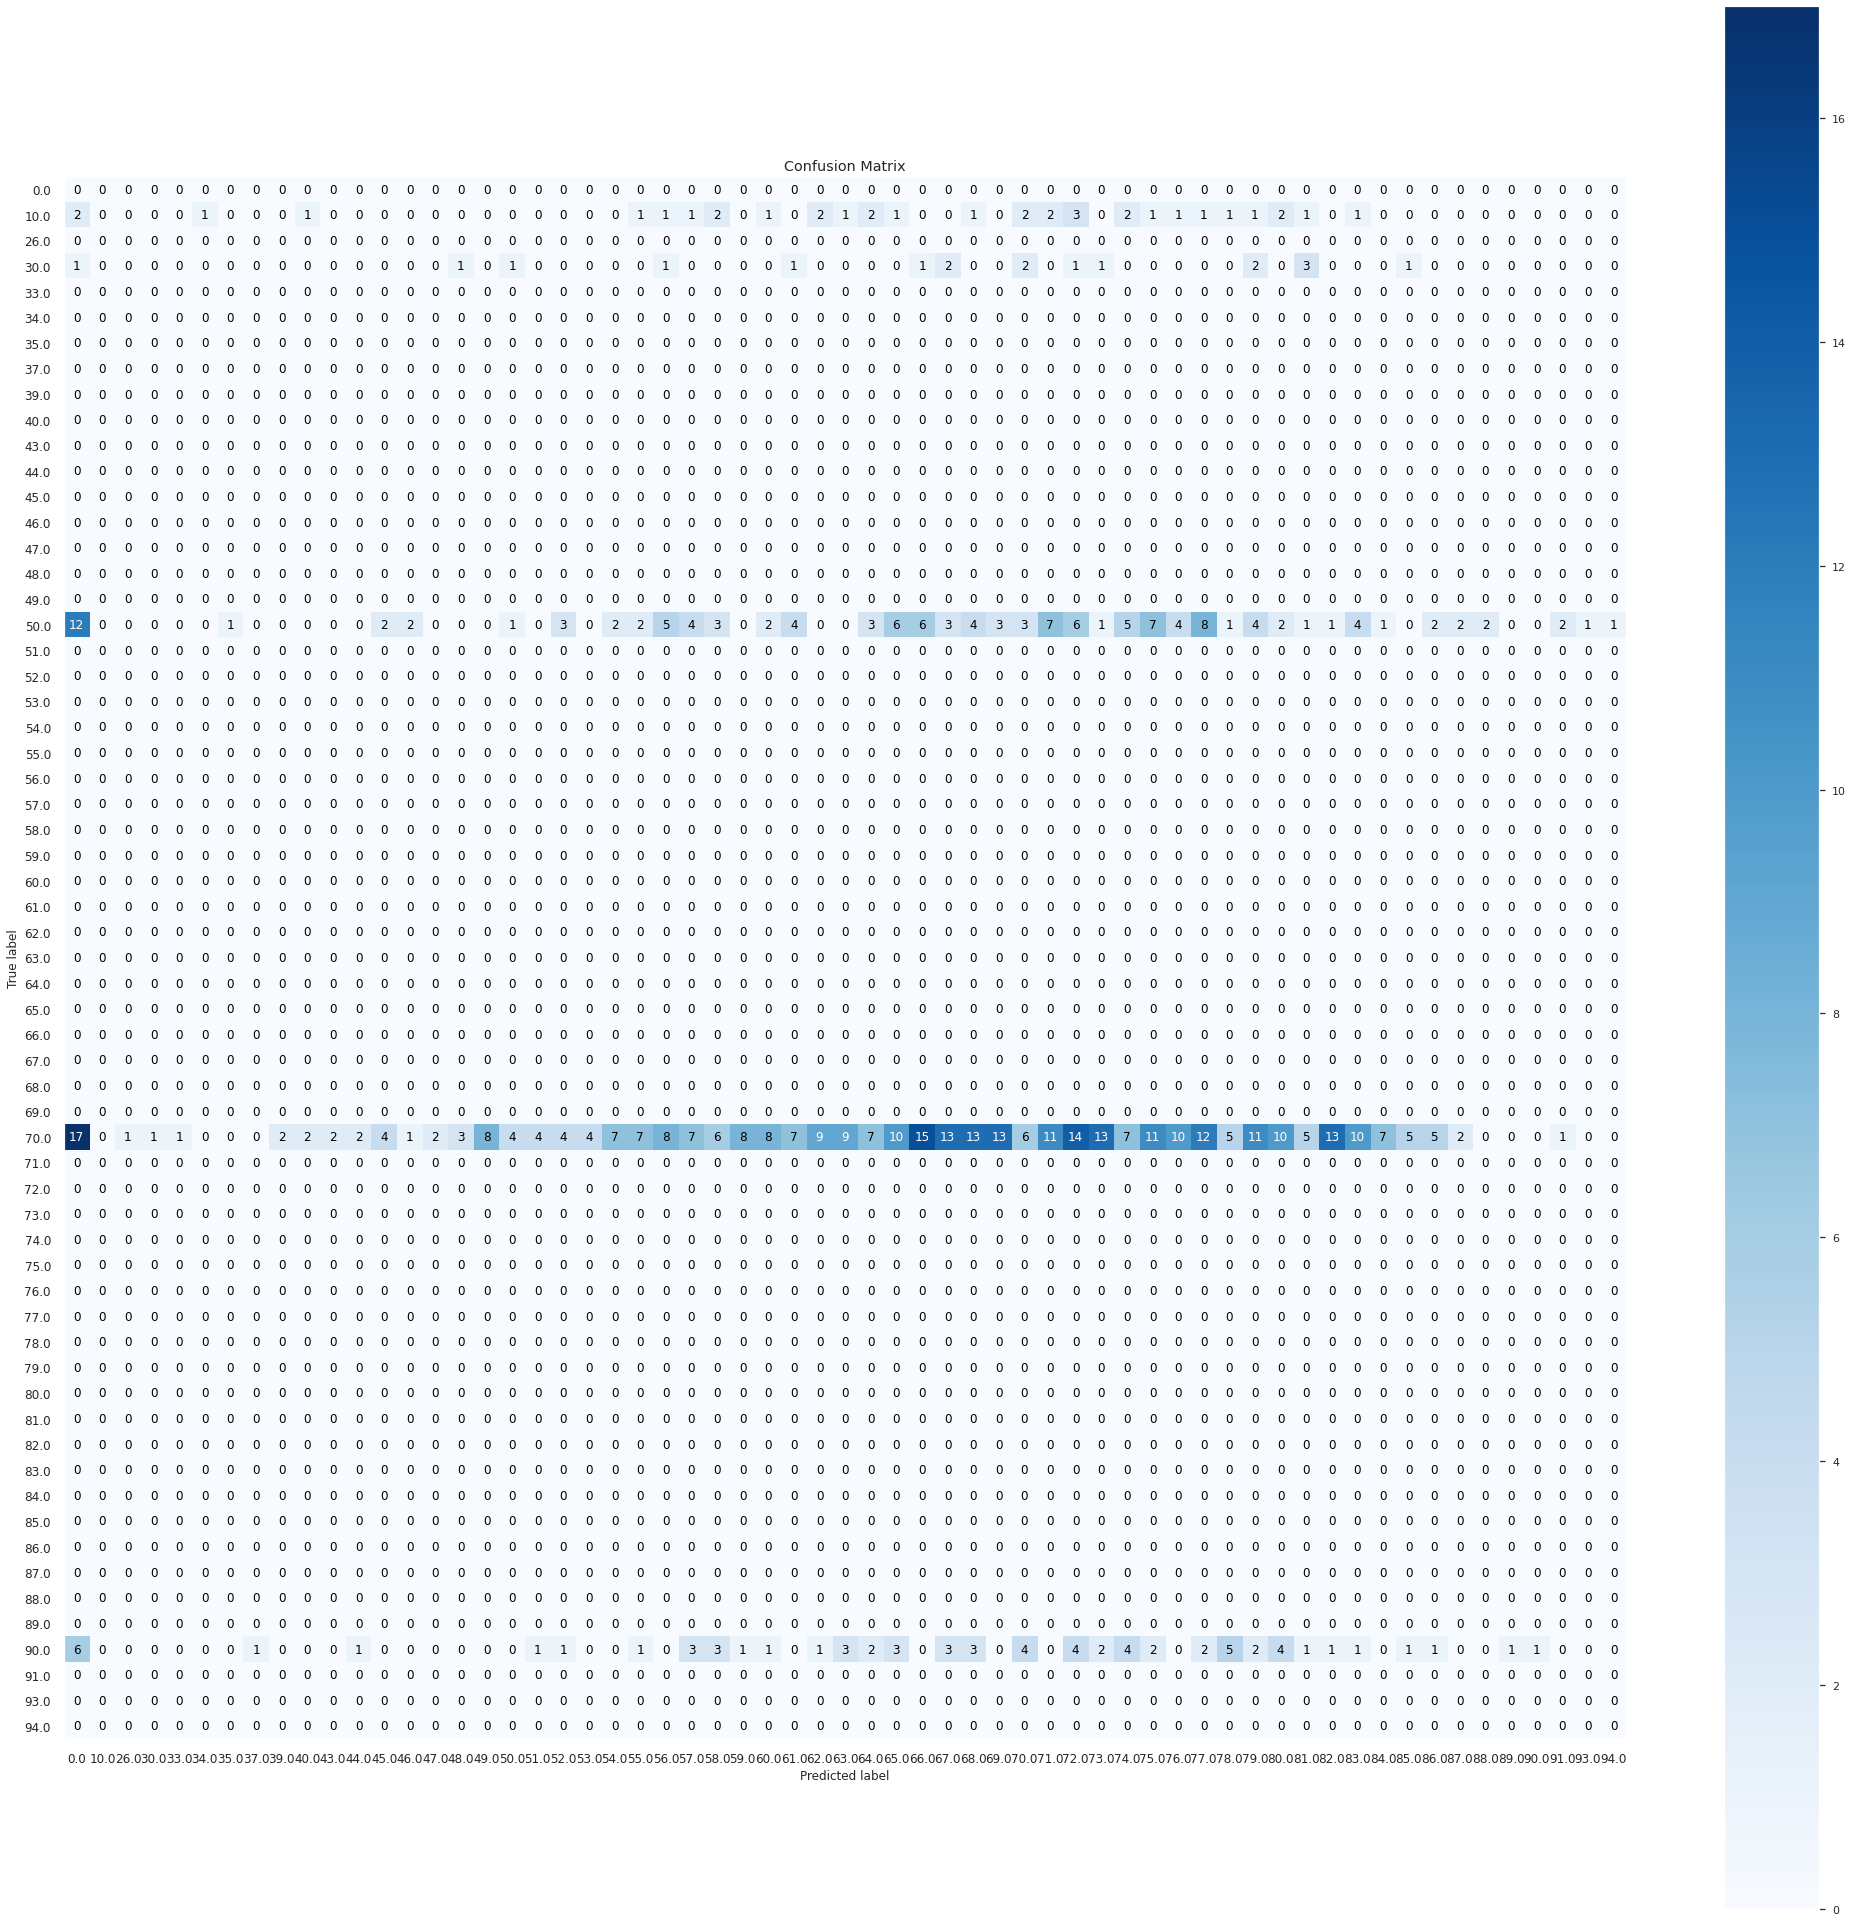

In [75]:
# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat_random, normalize=False, figsize=(35,35));

## 7.2. XGBoost To Multiclass Classification

### 7.2.1. Training and Testing

In [76]:
# definindo o modelo
xgb_model = xgb.XGBClassifier()

# treinando o modelo
xgb_model.fit(X_train, y_train)
pickle.dump(xgb_model, open('model/xgb.pkl', 'wb'))

# testando o modelo
yhat_xgb = xgb_model.predict(X_test)
pickle.dump(yhat_xgb, open('model/yhat_xgb.pkl', 'wb'))

[09:40:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [77]:
result_xgb = pd.DataFrame(["XGBoost Classifier",accuracy_score(y_test,yhat_xgb),cohen_kappa_score(y_test,yhat_xgb),
                          recall_score(y_test,yhat_xgb, average='macro'), f1_score(y_test,yhat_xgb, average='macro'),
                           precision_score(y_test,yhat_xgb, average='macro')]).T
result_xgb.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_Score"]

### 7.2.2. Performance

In [78]:
# Accuracy
acc_xgb = accuracy_score( y_test, yhat_xgb )
print( 'Accuracy: {}'.format( acc_xgb ) )

# Balanced Accuray
balanced_acc_xgb = balanced_accuracy_score( y_test, yhat_xgb )
print( '\nBalanced Accuracy:{}'.format( balanced_acc_xgb ) )

# Kappa Metrics
kappa_xgb = cohen_kappa_score( y_test, yhat_xgb )
print( '\nKappa Score: {}'.format( kappa_xgb ))

# Classification report
print( '\n', classification_report( y_test, yhat_xgb ) )

Accuracy: 0.5553772070626003

Balanced Accuracy:0.28578189342566224

Kappa Score: 0.12101563693780892

               precision    recall  f1-score   support

          10       0.50      0.26      0.34        35
          30       0.00      0.00      0.00        18
          50       0.36      0.27      0.31       133
          70       0.61      0.80      0.69       367
          90       0.32      0.10      0.15        70

    accuracy                           0.56       623
   macro avg       0.36      0.29      0.30       623
weighted avg       0.50      0.56      0.51       623



[09:40:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:40:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:40:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:40:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

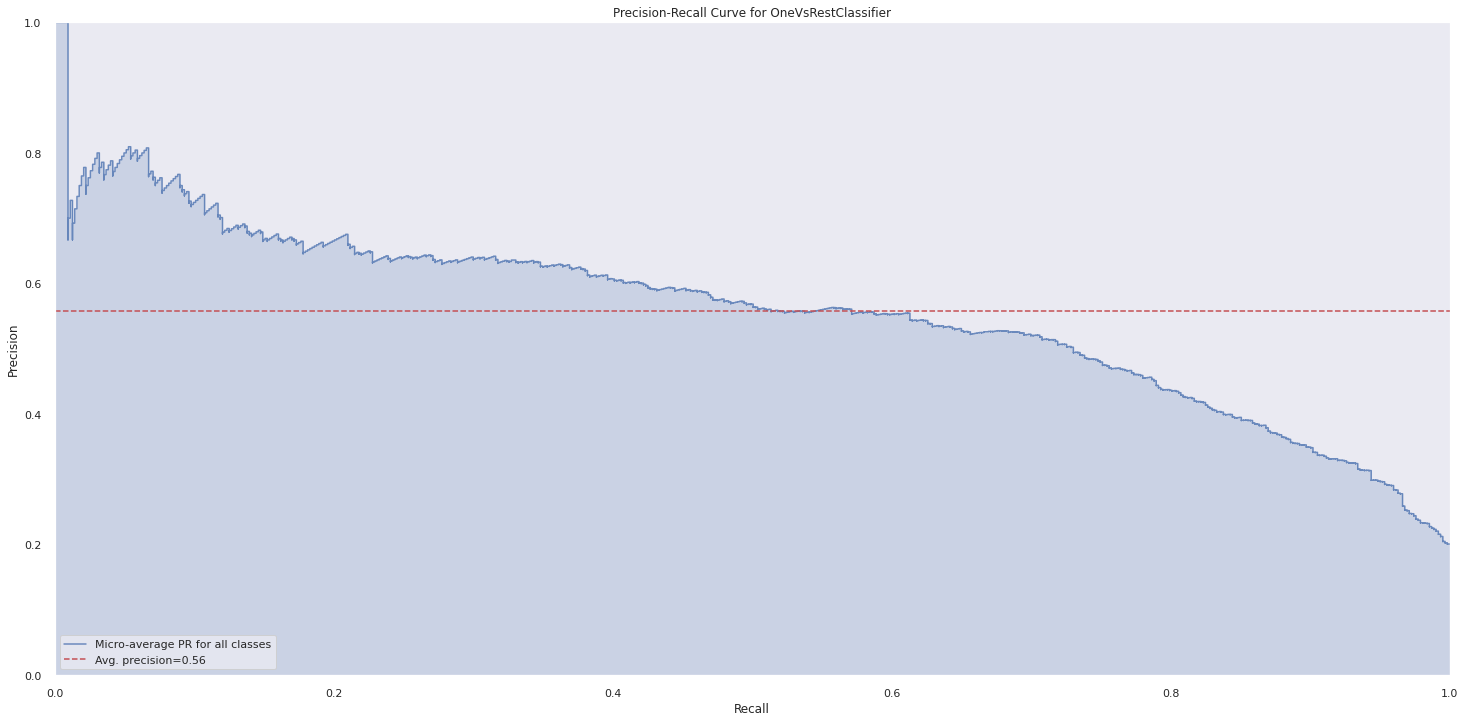

In [79]:
# criando a precision-recall curve
viz = PrecisionRecallCurve(
    OneVsRestClassifier(xgb.XGBClassifier()),
    per_class=False,
    cmap="Set1"
)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show();

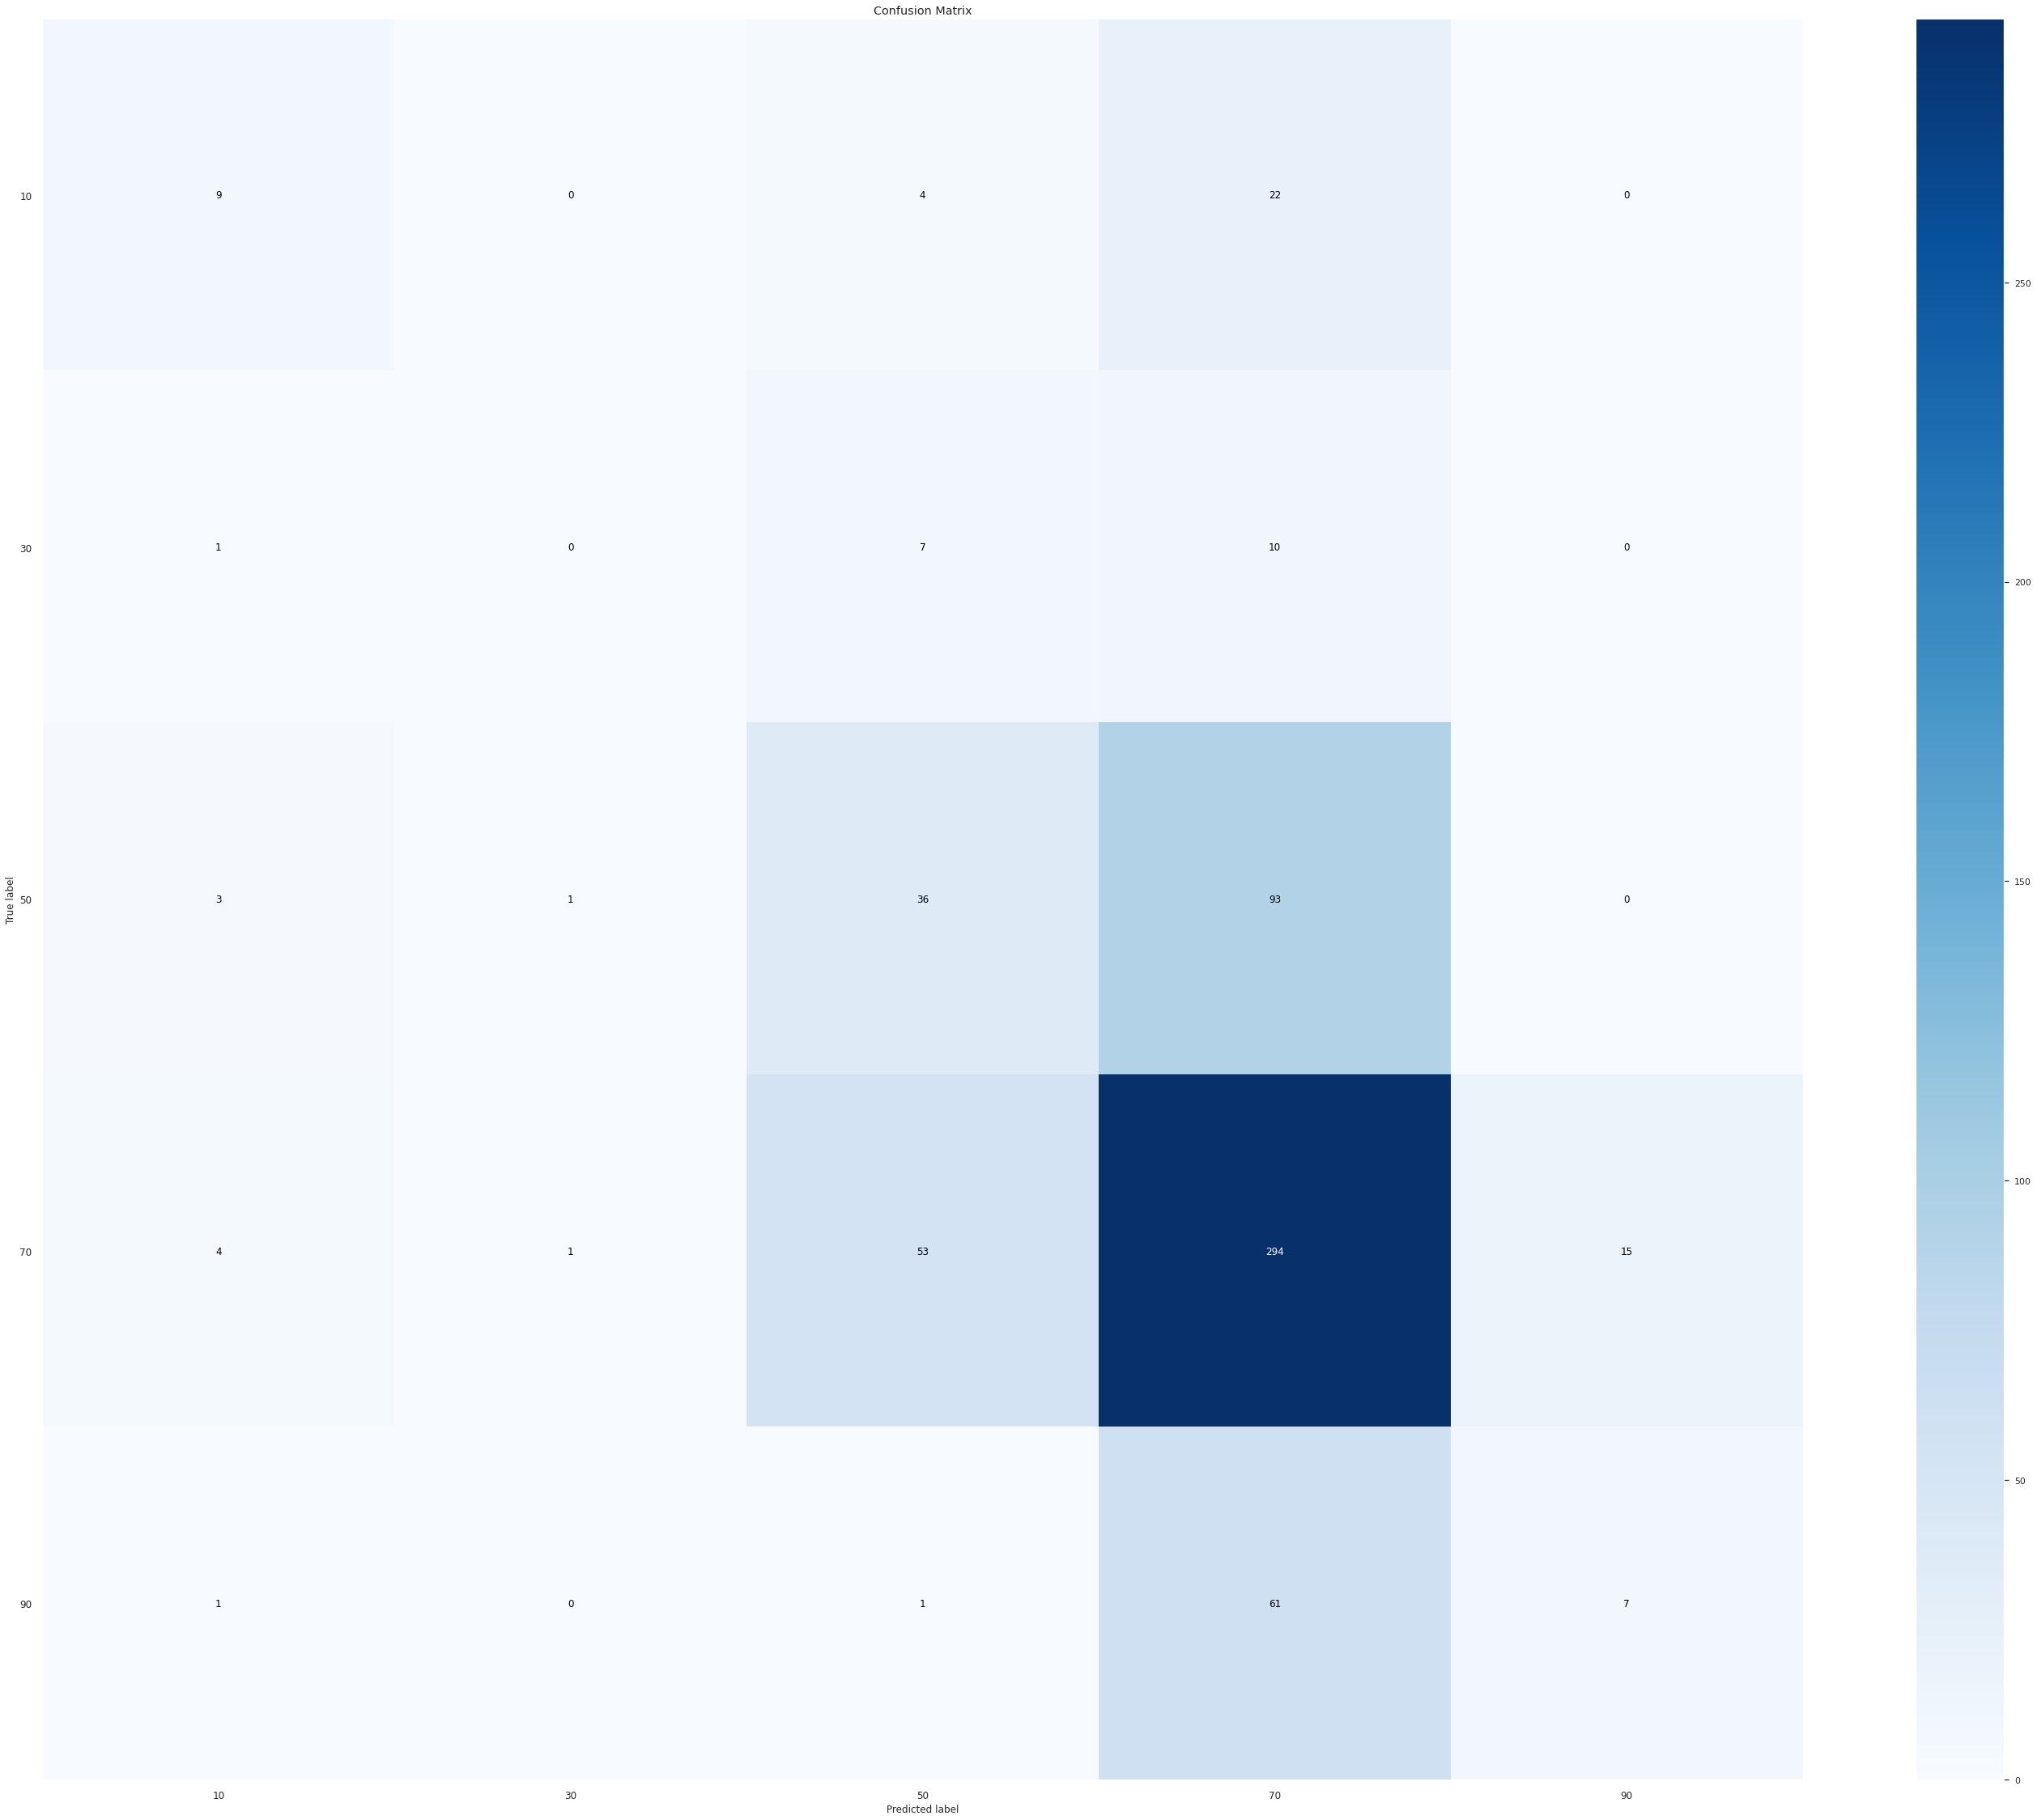

In [80]:
#confusion matrix
mt.plot_confusion_matrix(y_test, yhat_xgb, normalize = False, figsize = (50,40));

### 7.1.3. Cross-Validation

In [81]:
xgb_cv = cross_validation_multiclass( X, y, 10, 'XGBoost', xgb_model, verbose=False)
xgb_cv

[09:40:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:40:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:40:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:40:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

,Model Name,Accuracy CV,Kappa Score CV,Precision CV,Recall CV,F1-Score CV
0,XGBoost,0.58 +/- 0.01,0.18 +/- 0.01,0.44 +/- 0.03,0.32 +/- 0.01,0.34 +/- 0.02


## 7.3. Random Forest To Multiclass Classification

### 7.3.1. Training And Testing

In [82]:
# treinando o modelo
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10,criterion = 'entropy', random_state = 42, n_jobs=-1)

rf_model.fit(X_train, y_train)
pickle.dump(rf_model, open('model/rf.pkl', 'wb'))

# testando o modelo
yhat_rf = rf_model.predict(X_test)
pickle.dump(yhat_rf, open('model/yhat_rf.pkl', 'wb'))

In [83]:
result_rf = pd.DataFrame(["Random Forest Classifier",accuracy_score(y_test,yhat_rf),cohen_kappa_score(y_test,yhat_rf),
                          recall_score(y_test,yhat_rf, average='macro'), f1_score(y_test,yhat_rf, average='macro'),
                           precision_score(y_test,yhat_rf, average='macro')]).T
result_rf.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_Score"]

### 7.3.2. Performance

In [84]:
# Accuracy
acc_rf = accuracy_score( y_test, yhat_rf )
print( 'Accuracy: {}'.format( acc_rf ) )

# Balanced Accuray
balanced_acc_rf = balanced_accuracy_score( y_test, yhat_rf )
print( '\nBalanced Accuracy:{}'.format( balanced_acc_rf) )

# Kappa Metrics
kappa_rf = cohen_kappa_score( y_test, yhat_rf )
print( '\nKappa Score: {}'.format( kappa_rf ))

# Classification report
print( '\n', classification_report( y_test, yhat_rf ) )

Accuracy: 0.6019261637239165

Balanced Accuracy:0.27491139292372624

Kappa Score: 0.14829718972911587

               precision    recall  f1-score   support

          10       1.00      0.17      0.29        35
          30       0.00      0.00      0.00        18
          50       0.45      0.26      0.33       133
          70       0.62      0.90      0.74       367
          90       0.38      0.04      0.08        70

    accuracy                           0.60       623
   macro avg       0.49      0.27      0.29       623
weighted avg       0.56      0.60      0.53       623



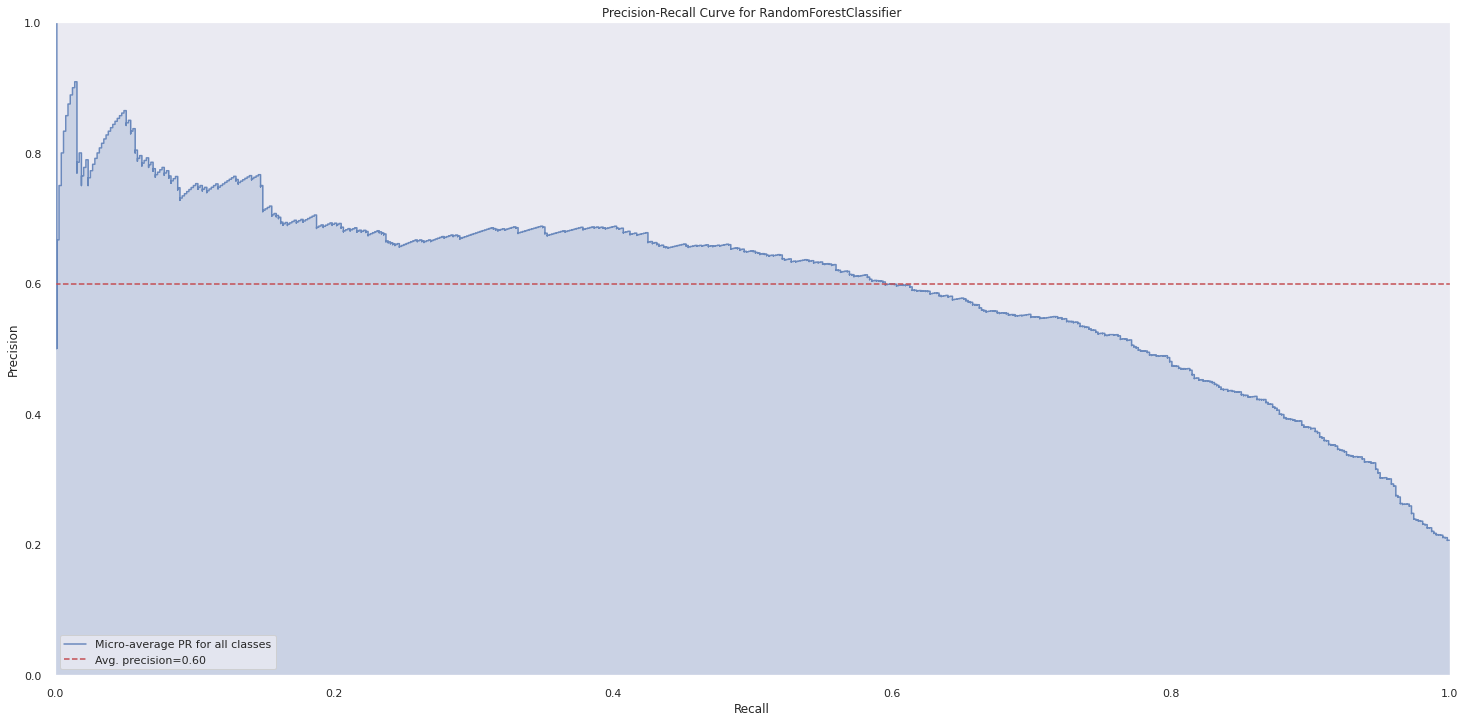

In [85]:
# criando a precision-recall curve
viz = PrecisionRecallCurve(
    RandomForestClassifier(n_estimators=100, max_depth=10,criterion = 'entropy', random_state = 42, n_jobs=-1),
    per_class=False,
    cmap="Set1"
)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show();

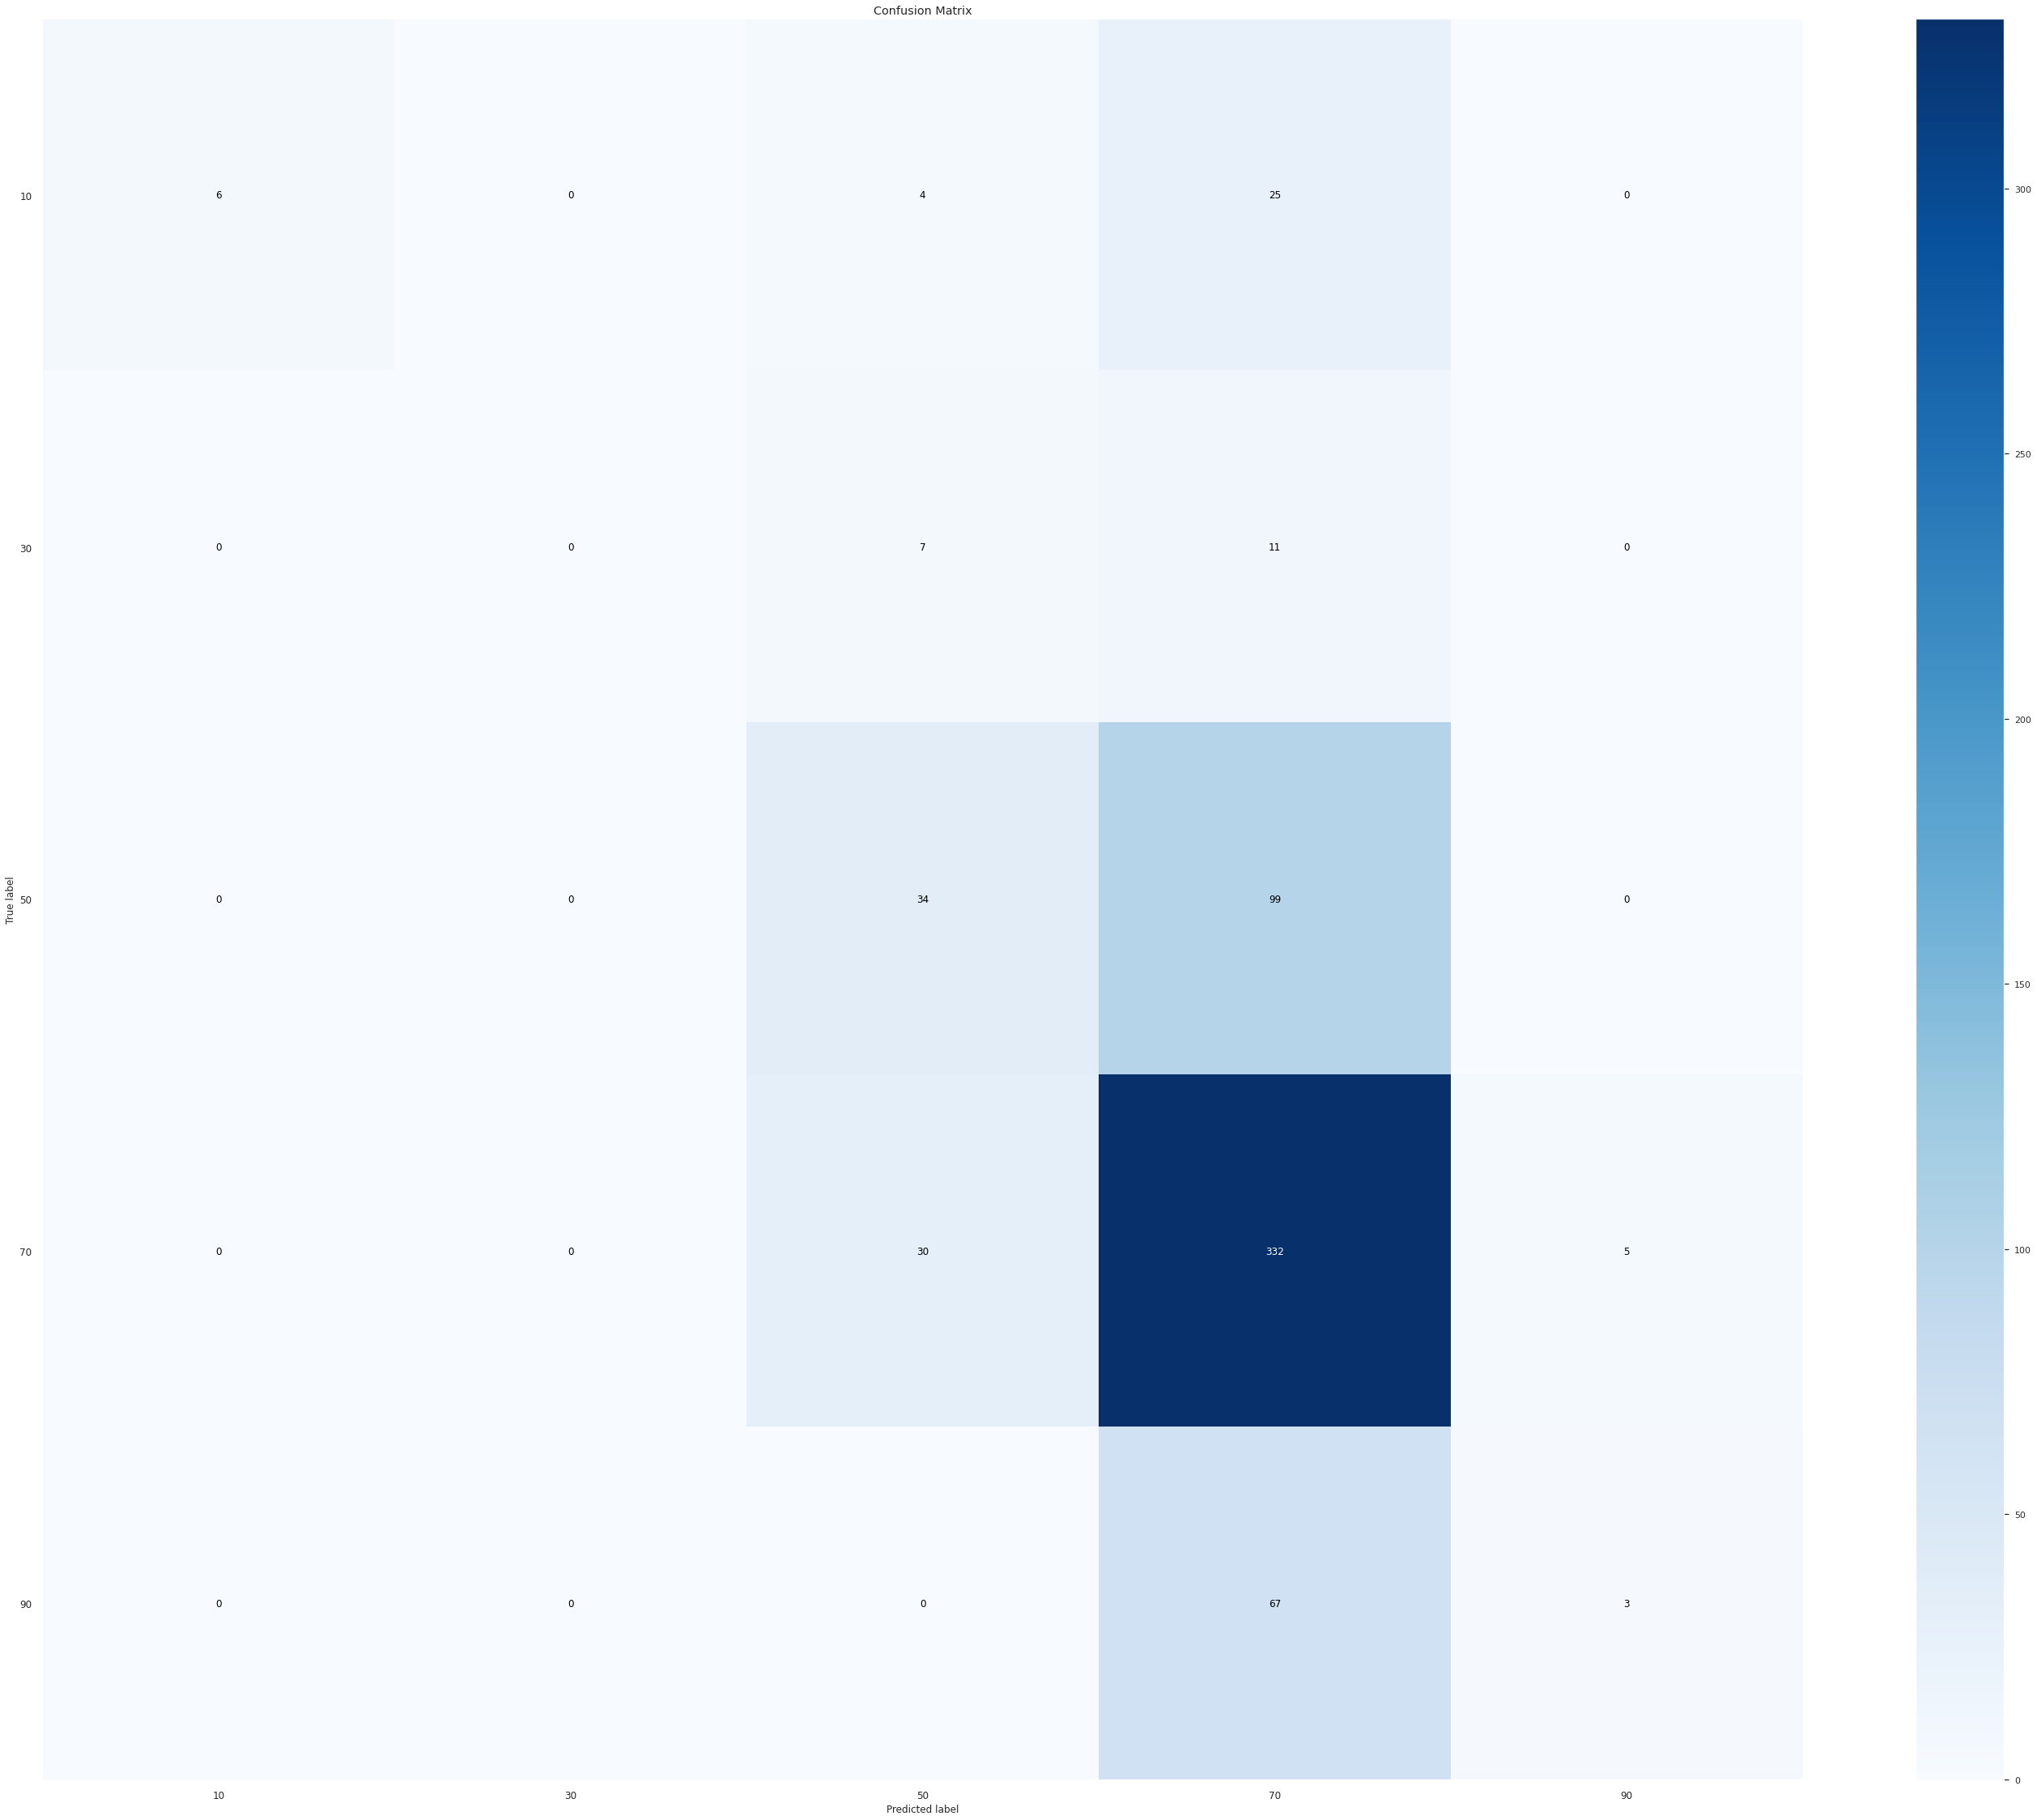

In [86]:
#confusion matrix
mt.plot_confusion_matrix(y_test, yhat_rf, normalize = False, figsize = (50,40));

### 7.3.3. Cross-Validation

In [87]:
rf_cv = cross_validation_multiclass( X, y, 10, 'Random Forest', rf_model, verbose=False)
rf_cv

,Model Name,Accuracy CV,Kappa Score CV,Precision CV,Recall CV,F1-Score CV
0,Random Forest,0.6 +/- 0.01,0.13 +/- 0.02,0.48 +/- 0.03,0.26 +/- 0.01,0.27 +/- 0.01


## 7.4. LGBM Classifier To Multiclass Classification

### 7.4.1. Treinando e Testando

In [88]:
# definindo o modelo
lgbm = LGBMClassifier(n_jobs = -1, max_depth=10)

# treinando o modelo
lgbm.fit(X_train.values, y_train.values)
pickle.dump(lgbm, open('model/lgbm.pkl', 'wb'))
#lgbm = pickle.load(open('model/lgbm.pkl', 'rb'))

# testando o modelo
yhat_lgbm = lgbm.predict(X_test)
pickle.dump(yhat_lgbm, open('model/yhat_lgbm.pkl', 'wb'))
#yhat_lgbm = pickle.load(open('model/yhat_lgbm.pkl', 'rb'))

In [89]:
result_lgbm = pd.DataFrame(["LGBM Classifier",accuracy_score(y_test,yhat_lgbm),cohen_kappa_score(y_test,yhat_lgbm),
                          recall_score(y_test,yhat_lgbm, average='macro'), f1_score(y_test,yhat_lgbm, average='macro'),
                           precision_score(y_test,yhat_lgbm, average='macro')]).T
result_lgbm.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_Score"]

### 7.4.2. Performance

In [90]:
# Accuracy
acc_lgbm = accuracy_score( y_test, yhat_lgbm )
print( 'Accuracy: {}'.format( acc_lgbm ) )

# Balanced Accuray
balanced_acc_lgbm = balanced_accuracy_score( y_test, yhat_lgbm )
print( '\nBalanced Accuracy:{}'.format( balanced_acc_lgbm) )

# Kappa Metrics
kappa_lgbm = cohen_kappa_score( y_test, yhat_lgbm )
print( '\nKappa Score: {}'.format( kappa_lgbm ))

# Classification report
print( '\n', classification_report( y_test, yhat_lgbm ) )

Accuracy: 0.5666131621187801

Balanced Accuracy:0.285799922148696

Kappa Score: 0.13731383087843096

               precision    recall  f1-score   support

          10       0.50      0.20      0.29        35
          30       0.00      0.00      0.00        18
          50       0.36      0.29      0.32       133
          70       0.62      0.81      0.70       367
          90       0.50      0.13      0.20        70

    accuracy                           0.57       623
   macro avg       0.40      0.29      0.30       623
weighted avg       0.53      0.57      0.52       623



In [91]:
2*((0.5*0.32)/(0.5+0.32))

0.39024390243902435

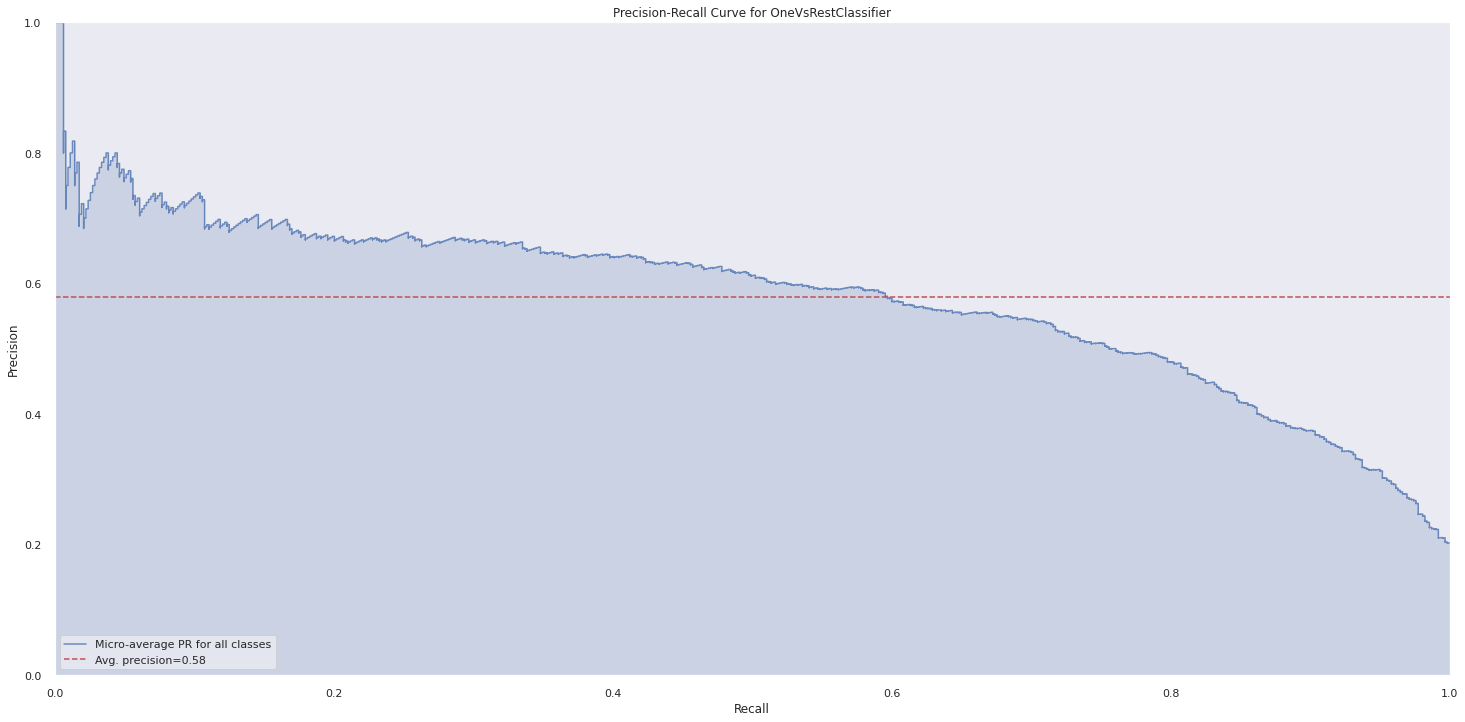

In [92]:
# criando a precision-recall curve
viz = PrecisionRecallCurve(
    OneVsRestClassifier(LGBMClassifier(n_jobs = -1, max_depth=10)),
    per_class=False,
    cmap="Set1"
)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show();

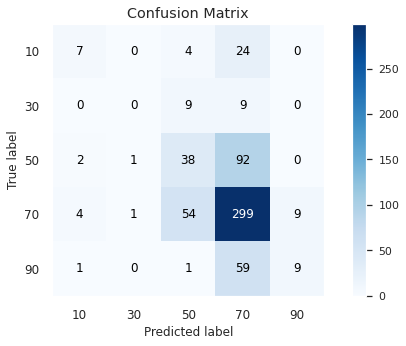

In [93]:
#confusion matrix
mt.plot_confusion_matrix(y_test, yhat_lgbm, normalize = False, figsize = (10,5));

### 7.4.3. Cross Validation

In [94]:
lgbm_cv = cross_validation_multiclass( X, y, 10, 'LGBM Model', lgbm, verbose=False)
lgbm_cv

,Model Name,Accuracy CV,Kappa Score CV,Precision CV,Recall CV,F1-Score CV
0,LGBM Model,0.58 +/- 0.01,0.17 +/- 0.02,0.43 +/- 0.03,0.3 +/- 0.01,0.32 +/- 0.02


## 7.5. Machine Learning Performance (All Models)

O modelo que teve a melhor performance foi o LGBM, logo ele foi selecionado para ser implementado nesse projeto.

### 7.5.1. Models Performance

In [95]:
# concatenando e mostrando
performance = pd.concat([result_random, result_xgb,result_rf,result_lgbm])
performance.sort_values('F1-Score', ascending = False)

,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_Score
0,LGBM Classifier,0.57,0.14,0.29,0.30,0.40
0,XGBoost Classifier,0.56,0.12,0.29,0.30,0.36
0,Random Forest Classifier,0.60,0.15,0.27,0.29,0.49
0,Baseline Model,0.01,-0.01,0.00,0.00,0.02


### 7.5.2. Cross Validation Performance

In [96]:
# concatenando e mostrando
performance = pd.concat([xgb_cv, rf_cv, lgbm_cv])
performance.sort_values('F1-Score CV', ascending = False)

,Model Name,Accuracy CV,Kappa Score CV,Precision CV,Recall CV,F1-Score CV
0,XGBoost,0.58 +/- 0.01,0.18 +/- 0.01,0.44 +/- 0.03,0.32 +/- 0.01,0.34 +/- 0.02
0,LGBM Model,0.58 +/- 0.01,0.17 +/- 0.02,0.43 +/- 0.03,0.3 +/- 0.01,0.32 +/- 0.02
0,Random Forest,0.6 +/- 0.01,0.13 +/- 0.02,0.48 +/- 0.03,0.26 +/- 0.01,0.27 +/- 0.01


# 8.0. Etapa 08 - Hyperparameter Fine Tuning

## 8.1. Random Search

Aqui foi utilizado o RandomSearch para poder achar os melhores parâmetros através de combinações aleatórias, pois outros métodos acabam por gastar muito tempo e poder computacional e em uma situação onde o HFP não poderá ajudar muito de qualquer forma (como a atual) não há motivos para gastar muito tempo.

In [97]:
#define model
rf_tuned = LGBMClassifier()

#parameters
param =  {'max_depth': np.arange(6, 18, 9), 
         'n_estimators': np.arange(45, 155, 60),
         'num_leaves': np.arange(20, 50, 30),
         'min_child_samples': np.arange(15, 60, 40),
         'colsample_bytree': np.arange(1, 5, 3)}

#define random search cv
rf_tuned_cv = RandomizedSearchCV(estimator=rf_tuned, param_distributions=param,
                                n_iter=100, cv=10, verbose=2,
                                random_state=42, n_jobs=-1)

# fit RandomSearchCV
rf_tuned_cv.fit(X_train, np.ravel(y_train))

pickle.dump(rf_tuned_cv, open('model/rf_tuned_cv.pkl', 'wb'))
#rf_tuned_cv = pickle.load(open('model/rf_tuned_cv.pkl', 'rb'))

Fitting 10 folds for each of 16 candidates, totalling 160 fits


In [98]:
rf_tuned_cv.best_estimator_

LGBMClassifier(colsample_bytree=1, max_depth=15, min_child_samples=55,
               n_estimators=45, num_leaves=20)

## 8.2. Tuned Random Forest

### 8.2.1. Model

In [99]:
# definindo o modelo com os parâmetros do random search
lgbm_tuned = LGBMClassifier(colsample_bytree=1, max_depth=15, min_child_samples=15,
               n_estimators=45, num_leaves=20)

# treinando o modelo
lgbm_tuned.fit(X_train, y_train)
pickle.dump(rf_tuned, open('model/rf_tuned.pkl', 'wb'))
#rf = pickle.load(open('model/rf_tuned.pkl', 'rb'))

# realizando a predição de teste
yhat_lgbm_tuned = rf_tuned.predict(X_test)
pickle.dump(yhat_rf_tuned, open('model/yhat_rf_tuned.pkl', 'wb'))
#yhat_rf_tuned = pickle.load(open('model/yhat_rf_tuned.pkl', 'rb'))

# salvando a performace
result_lgbm_tuned = pd.DataFrame(["LGBM Classifier Tuned",accuracy_score(y_test,yhat_rf_tuned),cohen_kappa_score(y_test,yhat_rf_tuned),
                          recall_score(y_test,yhat_rf_tuned, average='macro'), f1_score(y_test,yhat_rf_tuned, average='macro'),
                           precision_score(y_test,yhat_rf_tuned, average='macro')]).T
result_lgbm_tuned.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_Score"]

NotFittedError: Estimator not fitted, call `fit` before exploiting the model.

In [ ]:
# checando a performace
result_lgbm_tuned

### 8.2.2. Performance (com comentários)

O modelo conseguiu performar bem com a classificação de "70" sendo a que teve a melhor performance, embora o modelo ainda possa ser melhorado, ele já poderá produzir insights e trazer até um total de ao menos 40% do retorno esperado pela empresa vindoura dele.

In [ ]:
# Accuracy
acc_tuned_rf = accuracy_score( y_test, yhat_rf_tuned )
print( 'Accuracy: {}'.format( acc_tuned_rf ) )

# Balanced Accuray
balanced_acc_tuned_rf = balanced_accuracy_score( y_test, yhat_rf_tuned )
print( '\nBalanced Accuracy:{}'.format( balanced_acc_tuned_rf ) )

# Kappa Metrics
kappa_tuned_rf = cohen_kappa_score( y_test, yhat_rf_tuned )
print( '\nKappa Score: {}'.format( kappa_tuned_rf ))

# Classification report
print( '\n', classification_report( y_test, yhat_rf_tuned ) )

Nessa parte da curva de precision-recall vemos que há uma correlação negativa entre a precisão e o recall do modelo.

In [ ]:
# criando a precision-recall curve
viz = PrecisionRecallCurve(
    RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=45,
                       n_jobs=-1, random_state=42),
    per_class=False,
    cmap="Set1"
)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show();

Aqui na confusion matrix podemos ver que a classificação de "70" realmente tem acertado bem mais do que as outras.

In [ ]:
#confusion matrix
mt.plot_confusion_matrix(y_test, yhat_rf_tuned, normalize = False, figsize = (10,5));

# 9.0. Etapa 09 - Traduzindo Performance do Modelo

## 9.1. Copying Data to Analysis

In [ ]:
# copiando dados da coluna de testes
df9 = X_test.copy()

# copiando variável resposta de teste e predições
df9['rating'] = y_test.copy()
df9['predictions'] = yhat_rf_tuned.copy()

# resetando o index
df9 = df9.reset_index()

# criando a coluna id
df9['id'] = df9.index +1

## 9.2. Machine Learning Performance Interpretation

Nessa parte foquei em criar alguns gráficos que podessem demonstrar melhor (de forma visual) o erro do algoritmo selecionado e, devido a baixa acurácia do modelo, esses gráficos demonstraram que além do erro não possuir uma distribuição normal, ele ainda apresenta valores muito distorcidos.

In [ ]:
# criando variável de erro
df9['error'] = df9['rating'] - df9['predictions']

In [ ]:
# criando gráfico de distribuição para checar a distribuição dos erros
plt.subplot(1, 2, 1)
sns.distplot(df9['error']);

# criando gráfico de dispersão para checar a dispersão dos erros
plt.subplot(1, 2, 2)
sns.scatterplot(df9['predictions'], df9['error']);
sns.lineplot(df9['predictions'], df9['error']);

# 10.0. Etapa 10 - Deployment

Embora o modelo tenha um desempenho muito abaixo do necessário para ser eficientemente utilizado, como esse é um projeto criado por meio de um desáfio, estou optando por realizar o deployment dele para demonstrar como eu faria caso fosse-me requisitado.

O deployment ocorrerá através do **streamlit**, framework selecionado, pois possui um ambiente muito bom e fácil de se usar tanto para quem vai construir a estrutura do aplicativo web, quanto para quem irá usar efetivamente o modelo em produção, e a cloud selecionada é  o **"streamlit.io"**, pode checar o código de deployment abaixo:

In [ ]:
import pickle
import streamlit as st
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing     import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

#load the trained model
model = pickle.load(open('model.pkl', 'rb'))

# defining the prediction function
def predict(ReleaseYear, CastNum, DurMin, DurHour, WeekYe, WeekYeSin, WeekYeCos, MonYe, MonYeSin, 
            MonYeCos, DayWeek, DayWeekSin, DayWeekCos, AddedYe, CateNum, CountriesNum, 
            DayMon, DayMonSin, DayMonCos, DiffYe):
    
    # -------------------------------------MAKING PREDICTION----------------------------------
    
    # making the prediction
    yhat = model.predict([[ReleaseYear, CastNum, DurMin, DurHour, WeekYe, WeekYeSin, WeekYeCos, MonYe, MonYeSin, 
            MonYeCos, DayWeek, DayWeekSin, DayWeekCos, AddedYe, CateNum, CountriesNum, 
            DayMon, DayMonSin, DayMonCos, DiffYe]])
    
    # giving the answer
    prediction = (yhat)
    
    return prediction
    
def main():
    st.header('Multiclass Classification - Notas de Shows da Netflix')
    st.text("Autor: Valcilio Eugenio - Data Scientist")
    
    # ReleaseYear
    ReleaseYear = st.number_input('Digite o ano de lançamento:', value=0)
    
    # CastNum
    CastNum = st.number_input('Digite o número de pessoas no elenco:', value=0)
    
    # DurMin
    DurMin = st.number_input('Duração do show em minutos (considere 1 season igual a 600 minutos):', value=0)
    
    # DurHour
    if DurMin != 0:
        DurHour = DurMin/60 
    else:
        DurHour = 0
    
    # WeelYe
    WeekYe = st.number_input('Digite qual o número da semana no ano que o show foi adicionado  a Netflix:', value=0)
    
    # MonYe
    MonYe = st.number_input('Digite o mês do ano em numeral que o show foi adicionado a Netflix (1 = Janeiro e assim por diante):', value=0)
    
    # DayWeek
    DayWeek = st.number_input('Digite o número do dia da semana que o show foi adicionado a Netflix (0 = Segunda, ..., 6 = Domingo):', value=0)
    
    # AddedYe
    AddedYe = st.number_input('Digite o ano em que o show foi adicionado a Netflix:', value=0)
    
    # DiffYe
    if AddedYe != 0:
    	DiffYe = ReleaseYear - AddedYe
    else:
    	DiffYe = 0
    
    # CatNum
    CateNum = st.number_input('Digite o número de categorias:', value=0)
    
    # CountriesNum
    CountriesNum = st.number_input('Digite o número de países lançado (considere 1, caso não saiba):', value=0)
    
    # DayMon
    DayMon = st.number_input('Digite o dia do mês (de 1 a 30, considere 30 se for 31):', value=0)
    
    # preparing the dataset
    if DayMon != 0:
    
        # # -------------------------------------RESCALING----------------------------------

        # -------------------------------------STANDARDSCALER----------------------------------

        #ReleaseYear
        ss = pickle.load(open('scalers/release_year_scaler.pkl', 'rb'))
        RY = (ss.transform([[ReleaseYear]]))[0]
        ReleaseYear = RY[0]

        # day_of_month
        ss = pickle.load(open('scalers/day_of_month_scaler.pkl', 'rb'))
        DM = (ss.transform([[DayMon]]))[0]
        DM = DM[0]

        # day_of_week
        ss = pickle.load(open('scalers/day_of_week_scaler.pkl', 'rb'))
        DW = (ss.transform([[DayWeek]]))[0]
        DayWeek = DW[0]

        # added_year
        ss = pickle.load(open('scalers/added_year_scaler.pkl', 'rb'))
        AY = (ss.transform([[AddedYe]]))[0]
        AddedYe = AY[0]

        # month_of_year
        ss = pickle.load(open('scalers/month_of_year_scaler.pkl', 'rb'))
        MY = (ss.transform([[MonYe]]))[0]
        MonYe = MY[0]

        # week_of_year
        ss = pickle.load(open('scalers/week_of_year_scaler.pkl', 'rb'))
        WY = (ss.transform([[WeekYe]]))[0]
        WeekYe = WY[0]

        # -------------------------------------ROBUSTSCALER----------------------------------

        # duration_min
        rs = pickle.load(open('scalers/duration_min_scaler.pkl', 'rb'))
        DM = (rs.transform([[DurMin]]))[0]
        DurMin = DM[0]

        # duration_hour
        rs = pickle.load(open('scalers/duration_hour_scaler.pkl', 'rb'))
        DH = (rs.transform([[DurHour]]))[0]
        DurHour = DH[0]

        # -------------------------------------MINMAXSCALER----------------------------------

        # num_of_cast
        mms = pickle.load(open('scalers/num_of_cast_scaler.pkl', 'rb'))
        CN = (mms.transform([[CastNum]]))[0]
        CastNum = CN[0]

        # num_of_countries
        mms = pickle.load(open('scalers/num_of_countries_scaler.pkl', 'rb'))
        CON = (mms.transform([[CountriesNum]]))[0]
        CountriesNum = CON[0]

        # num_of_categories
        mms = pickle.load(open('scalers/num_of_categories_scaler.pkl', 'rb'))
        CAN = (mms.transform([[CateNum]]))[0]
        CateNum = CAN[0]
        
        # diff_bet_years
        mms = pickle.load(open('scalers/diff_bet_years_scaler.pkl', 'rb'))
        DY = (mms.transform([[DiffYe]]))[0]
        DiffYe = DY[0]

        # -------------------------------------TRANSFORMATION----------------------------------

        # ----------------------------------NATURE TRANSFORMATION----------------------------------

        # day_of_week
        DayWeekSin = np.sin(DayWeek*(2.*np.pi/7))
        DayWeekCos = np.cos(DayWeek*(2.*np.pi/7))

        # day_of_month
        DayMonSin = np.sin(DayMon*(2.*np.pi/30))
        DayMonCos = np.cos(DayMon*(2.*np.pi/30))

        # month_of_year
        MonYeSin = np.sin(MonYe*(2.*np.pi/12))
        MonYeCos = np.cos(MonYe*(2.*np.pi/12))

        # week_of_year
        WeekYeSin = np.sin(WeekYe*(2.*np.pi/52))
        WeekYeCos = np.cos(WeekYe*(2.*np.pi/52))
    
    if st.button('Prediction'):
        
        # fazendo a predição
        result = predict(ReleaseYear, CastNum, DurMin, DurHour, WeekYe, WeekYeSin, WeekYeCos, MonYe, MonYeSin, 
            MonYeCos, DayWeek, DayWeekSin, DayWeekCos, AddedYe, CateNum, CountriesNum, 
            DayMon, DayMonSin, DayMonCos, DiffYe)
        
        # informando os resultados
        st.success('A nota do seu show indicado será {:.0f}'.format(result[0]))
        
if __name__ == '__main__':
    main()

# 11.0. Etapa 11 - Retorno Financeiro

Infelizmente, como o desempenho do modelo foi baixo, não há um grande retorno financeiro visualmente citável, mas, **se formos considerar que o modelo tivesse ao menos 90% de precision e recall**, o tornando utilizável, esse modelo poderia ajudar a Netflix em vários pontos como:

- Melhor planejamento do investimento em certas shows.


- Compreender quanto cada show deve render em média.


- Compreender quais os gêneros de shows mais amados pelas pessoas.


- Identificar quais shows devem receber uma sequência ou não.


- Compreender quais shows de terceiros devem ter maior investimento na aquisição.


- Realizar o valuation por show.


- Identificar qual show irá precisar de maior marketing ou terá melhor efeito caso receba mais atenção.


- Identificar qual capa de show deverá ser utilizado para divulgar novos lançamentos (devido a ter uma tendência de obter melhores avaliações e servir como uma melhor primeira impressão).

Esses pontos poderiam ajudar muito a Netflix reduzindo bastante suas despesas, aumentando bastante sua receita e também direcionando melhor seus investimentos, tudo isso em conjunto poderia aumentar seu lucro em cerca de 30% a 50%, pois os shows são de fato o "main business" da Netflix e cada informação referente a eles poderiam ajudar a Netflix a melhorar seu desempenho como empresa.

# 12.0. Etapa 12 - Próximos Passos e Conclusão

## 12.1. Próximos Passos

### 11.1.1. Para Um Modelo Com Melhor Desempenho

Tendo em vista que o modelo possui uma performance bem abaixo do requerido para poder ser utilizável, eu recomendo inicialmente passos para poder melhorar a performance desse modelo que seriam os seguintes:

- Obter mais features que possam ter relação com as notas como o tempo assistido de cada show.


- Obter variáveis como a quantidade de visitas (mesmo que sem ser assistidas) cada show recebe.


- Obter informações de outras plataformas de streaming, caso possível, de shows já presentes na Netflix para comparação.


- Obter informações de shows de outras plataformas de streaming para que o modelo possa ter uma base ainda melhor para comparação.


- Obter features do time de marketing, como o valor do investimento em marketing de cada show e a quantidade de tempo que ele passou sendo divulgado.


- Obter features do time de compras informando fornecendo um rating anterior recebido pelo filme quando estava em outras plataformas (caso não seja original Netflix).


- Criar uma ferramenta de pesquisa (seleção) para clientes que colocaram o rating explicar o motivo de colocarem esse rating e podermos ter mais uma variável de peso explicando o rating dos filmes.

Através da obtenção dessas features será possível ter uma base mais sólida na quando for realizar o treinament odo modelo. Porém ainda é importante citar que **o número de linhas (shows) fornecidos é muito baixo logo precisaria ser aumentado** e sobre o quanto precisaria ser aumentado, eu estipulo o seguinte:

Acredito que o rating iria de 0 até 100, fazendo com que haja um total de 101 ratings diferentes e, para cada rating, seria necessário cerca de 3500 produtos, esse julgamento é tendo em base que existem cerca de 330 produtos com rating 0 e esse rating 0 foi o único que começou a ter bons retornos de métrica (apresentou um recall por volta de 70%, mesmo que as outras métricas tenham sido bem baixas ainda), desse modo julgo que seria necessário aproximadamente 10 vezes essa quantidade, fazendo algo por volta de 3500. Logo adicionado também:

- Obter cerca de 3500 shows por rating (total de 353500 shows para poder haver uma previsão utilizável).

Ademais, também admito que o **ideal nesse caso seria utilizar uma rede neural que poderia considerar os padrões nos outros shows para poder identificar o rating que deve ser adquirido em cada show**, logo, adiciono mais essa medida a ser tomada:

- Estudar e implementar uma rede neural que possa considerar padrões em outras notas e consequentemente ter um melhor desempenho ao classificar as notas dos shows.

Enfim, é plausível acreditar que seguindo esses passos seja possível criar um modelo que seja capaz de prever de forma eficiente as notas que cada filme deve vir a receber.

### 11.1.2. Pós-Desenvolvimento De Um Modelo Com Melhor Desempenho

Uma vez que um modelo com melhor desempenho tenha sido desenvolvido, é necessário passar para os próximos passos que seria ensinar o time de negócios a utilizá-lo após pô-lo em produção. Desse modo, **deve ser feita uma reunião** onde irá ser levantando os seguintes pontos:

- Explicação do contexto de negócio.


- Explicação do porquê aquele projeto foi necessário.


- Explicação da performance do modelo.


- Explicação de como esse modelo pode ser útil para o time.


- Explicação sobre como o aplicativo web funcionará.


- Explicação sobre como o resultado desse modelo ajudará toda a empresa (incluindo o efeito dominó dele).


- Explicação sobre o retorno financeiro dele.


Uma vez feita essa reunião e explicado tudo isso será necessário que haja então mais algumas reuniões com o time que irá mais se beneficiar e utilizar a aplicação web para que ele possa compreender a fundo como ela funciona e extrair o máximo de resultado que a aplicaçao web poderá fornecer.

## 12.2. Conclusão

Enfim, uma vez concluídos os passos da parte "**12.1. Próximos Passos**" deverá ser possível ter um modelo eficiente que trará os resultados financeiros esperados pela "**Etapa 11**", assim possibilitando a Netflix e ao time de dados produzirem outros modelos que possam ajudar a Netflix a produzir ainda mais insights para seu negócio, além de estar sempre trabalhando na atualização do modelo já produzido para garantir que ele não perca sua funcionalidade.